In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

from matplotlib.lines import Line2D


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

In [5]:
def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [6]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Select dataset

In [7]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# ----------------------------------------------------------------------------------------------------
# Aggregate projection results
This is output of classifications/aggregate_gradient_estimates()


In [8]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    return

## Set analysis parameters

In [12]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'
rf_fit_thr=0.5
do_spherical_correction=True
rf_type = 'sphr' if do_spherical_correction else ''
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
print(rf_fit_desc)

#### Filter RF datasets by
rf_filter_by='drop_repeats_%s' % rf_type

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr

##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)


fit-2dgaus_dff_sphr
pixels_thr-0.003


In [10]:
# Set data identifiers

retino_dataid = 'retinobar_%s-thr-%.3f' % (pass_criterion, mag_thr)
rf_dataid = 'rfs_%s-thr-%.3f' % (rf_filter_by, rf_fit_thr)

data_id = '%s|%s|%s|%s' % (fov_type, state, retino_dataid, rf_dataid)
print(data_id)


zoom2p0x|awake|retinobar_pixels-thr-0.003|rfs_drop_repeats_sphr-thr-0.500


# Set output dirs

In [20]:
basedir = os.path.join(aggr_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc), 'scatter')

if not os.path.exists(basedir):
    os.makedirs(basedir)
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter'

# Load datasets

In [21]:
# Get datasets that have BOTH rfs and retinogradient measured
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
bothdata = pd.concat([g for s, g in sdata.groupby(['animalid', 'session', 'fov']) \
                        if ('retino' in sdata['experiment'].values) and \
                        ('rfs' in sdata['experiment'].values or 'rfs10' in sdata['experiment'].values)])
bothdata['datakey'] = ['_'.join([session, animalid, 'fov%i' % fovnum]) \
                         for (session, animalid, fovnum) in bothdata[['session', 'animalid', 'fovnum']].values]

common_datakeys = bothdata['datakey'].unique()

In [22]:
bothdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [23]:
retdata = bothdata[bothdata['experiment']=='retino'].copy()
print("N retinobar experiment fovs:")
print(retdata.groupby(['visual_area']).count())

N retinobar experiment fovs:
             animalid  experiment  fov  session  fovnum  datakey
visual_area                                                     
Li                 23          23   23       23      23       23
Lm                 19          19   19       19      19       19
V1                 15          15   15       15      15       15


In [24]:
print("Threshold info: %s" % magthr_str)
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    
    datakey = '_'.join([session, animalid, fov, retinorun])
    try:
        fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                                'retino_analysis', 'retino_structure', 
                                        'projections_%s.pkl' % magthr_str)) # 'projection_results.pkl'))
        assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))
    except Exception as e:
        errors.append(datakey)
        continue
    proj_fit_paths.append((animalid, session, fov, retinorun, retinoid, fpaths[0]))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

Threshold info: pixels_thr-0.003
skipping, no retino (JC076, 20190502, FOV1_zoom2p0x)
skipping, no retino (JC091, 20191007, FOV1_zoom2p0x)
skipping, no retino (JC092, 20190527, FOV2_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV1_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV3_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV1_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV4_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV3_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV4_zoom2p0x)
60 of 60 paths found


In [98]:
errors

[]

# Load gradient data

In [25]:
# Create dir to copy gradient images to, for visual inspection
copy_images = False

if copy_images:
    dst = os.path.join(dst_dir, 'individual_session_inputs')
    if not os.path.exists(dst):
        os.makedirs(dst)
    delete_files(dst)
    print(dst)

In [26]:
d_list=[]
for di, (animalid, session, fov, retinorun, retinoid, fpath) in enumerate(proj_fit_paths):
    if di % 20 == 0 or di==(len(proj_fit_paths)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(proj_fit_paths)))
        
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    visual_area = retdata[(retdata['animalid']==animalid) 
                          & (retdata['session']==session) 
                          & (retdata['fov']==fov)]['visual_area'].values[0]
    metainfo = {'visual_area': visual_area, 'animalid': animalid, 'session': session, 'fov': fov,
               'retinorun': retinorun, 'retinoid': retinoid, 'datakey': datakey, 'fpath':fpath}
    tmpd = putils.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' % (visual_area, datakey, retinorun, fname, fext)))
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)

projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

print(projection_df.shape)
projection_df.head()

1 of 60 gradient result files loaded.
21 of 60 gradient result files loaded.
41 of 60 gradient result files loaded.
60 of 60 gradient result files loaded.
(120, 17)


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,retinorun,fov,session,animalid,datakey,visual_area,retinoid,fpath,abs_coef,cortical_mag
0,0.545824,15.029276,0.049545,az,38.375491,0.0,0.738799,retino_run1,FOV1_zoom2p0x,20190420,JC076,20190420_JC076_fov1,V1,analysis002,/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...,0.049545,20.183516
1,0.747663,6.524156,0.036184,el,-18.948086,0.0,0.864675,retino_run1,FOV1_zoom2p0x,20190420,JC076,20190420_JC076_fov1,V1,analysis002,/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...,0.036184,27.636162
2,0.175167,8.945338,0.012529,az,4.287611,0.0,0.418529,retino_run1,FOV1_zoom2p0x,20190422,JC076,20190422_JC076_fov1,Li,analysis002,/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...,0.012529,79.816001
3,0.010267,2.858159,0.000923,el,3.184619,0.0,0.101329,retino_run1,FOV1_zoom2p0x,20190422,JC076,20190422_JC076_fov1,Li,analysis002,/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...,0.000923,1082.896855
4,0.991063,1.404291,0.050939,az,42.383800,0.0,0.995521,retino_run1,FOV1_zoom2p0x,20190423,JC076,20190423_JC076_fov1,Lm,analysis002,/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0...,0.050939,19.631440


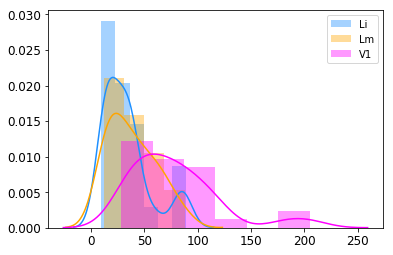

In [27]:
r2_thr=0.75
fig, ax = pl.subplots()
for visual_area, g in projection_df[projection_df['R2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['cortical_mag'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()

In [102]:
# # Load 1 fov to test sth
# animalid='JC110'
# session = '20191006'
# fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
# print(fpath)
# with open(fpath, 'rb') as f:
#     res = pkl.load(f)
# print(res['regr_az'].coef_, res['regr_az'].intercept_)
# p_df = res['regr_df'].copy()
# print(p_df)

# # gradient info
# grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
# with open(grad_fpath, 'rb') as f:
#     gresults = pkl.load(f)
# gresults.keys()


# Cortical magnification

In [28]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10),
                          area_colors=None, legend=True):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)
    
    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

    return fig


In [29]:
def plot_axis_distributions(projdf, currmetric='abs_coef', hue='cond',
                            currcols=['windows blue', 'amber'], area_colors=None,
                             fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10)):

    bi_palette = sns.xkcd_palette(currcols)

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    sns.stripplot(x='visual_area', y=currmetric, hue=hue, data=projdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", currmetric, data=projdf,
               hue=hue, order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    #ax.set_ylim([0, 0.12])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    pl.legend(bbox_to_anchor=((1.2, 1)))
    projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.2), fontsize=8)

    return fig

# Filter retino gradient results
- (Set some R2 threshold)
- "Bad" fits suggests that the retino gradient was messed up or points were all over the place?
- Also, drop extra run (retino_run1, and retino_run2)
- May have duplicate FOVS.

In [30]:
projection_df[['visual_area', 'datakey', 'retinorun']].drop_duplicates()['visual_area'].value_counts()

Li    24
Lm    20
V1    16
Name: visual_area, dtype: int64

In [31]:
repeat_retinos = pd.concat([g for k, g in projection_df.groupby(['visual_area', 'datakey']) \
                            if len(g['retinorun'].unique())>1], axis=0)


In [32]:
repeat_retinos[['visual_area', 'datakey', 'retinorun']].drop_duplicates()

,visual_area,datakey,retinorun
52,Li,20190605_JC090_fov1,retino_run1
54,Li,20190605_JC090_fov1,retino_run2
28,Lm,20190508_JC083_fov1,retino_run1
30,Lm,20190508_JC083_fov1,retino_run2
44,Lm,20190525_JC084_fov1,retino_run1
46,Lm,20190525_JC084_fov1,retino_run2
24,V1,20190507_JC083_fov1,retino_run1
26,V1,20190507_JC083_fov1,retino_run2
40,V1,20190522_JC084_fov1,retino_run1
42,V1,20190522_JC084_fov1,retino_run2


In [33]:
# sns.pairplot(repeat_retinos, hue='retinorun', palette='colorblind')

# Remove repeat runs

In [34]:
gradient_df = pd.concat([g[g['retinorun']=='retino_run2'] if len(g['retinorun'].unique())>1 else g for k, g in projection_df.groupby(['visual_area', 'datakey'])], axis=0)
gradient_df['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in gradient_df[['datakey', 'retinorun']].values]
print(projection_df.shape, gradient_df.shape)


((120, 17), (110, 18))


In [35]:
gradient_df[(gradient_df['visual_area']=='Li')][['datakey', 'R2', 'cond']]

,datakey,R2,cond
2,20190422_JC076_fov1,0.175167,az
3,20190422_JC076_fov1,0.010267,el
50,20190522_JC089_fov1,0.901562,az
51,20190522_JC089_fov1,0.746420,el
68,20190527_JC092_fov3,0.979097,az
69,20190527_JC092_fov3,0.865969,el
70,20190528_JC092_fov1,0.962362,az
71,20190528_JC092_fov1,0.320390,el
18,20190602_JC080_fov1,0.365193,az
19,20190602_JC080_fov1,0.293169,el


# Filter FOVs, only select good gradient fits

In [36]:
retino_r2_thr=0.7
all_retino_datakeys = gradient_df['datakey'].unique()
    
# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in gradient_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(gradient_df.shape, projdf.shape)

# Get datakeys for FOVs that pass
pass_retino_datakeys = projdf['datakey'].unique()
fail_retino_datakeys = [r for r in projection_df['datakey'].unique() if r not in pass_retino_datakeys]
print("%i of %i retinokeys pass threshold (R2=%.2f)" % (len(pass_retino_datakeys), len(all_retino_datakeys), retino_r2_thr))


((110, 18), (62, 18))
31 of 55 retinokeys pass threshold (R2=0.70)


In [78]:
exclude_retinos = [ '20190605_JC090_fov1', '20191106_JC120_fov1', '20191111_JC120_fov1']

In [79]:
include_retinos = ['20190527_JC092_fov3', '20190609_JC099_fov1', '20190612_JC099_fov1', '20191003_JC111_fov1',
                  '20190617_JC099_fov1', '20191105_JC117_fov1', '20191106_JC120_fov1'] #, '20191111_JC120_fov1']

exclude_retinos = projdf[(projdf['visual_area']=='Li') & ~(projdf['datakey'].isin(include_retinos))]['datakey'].unique()

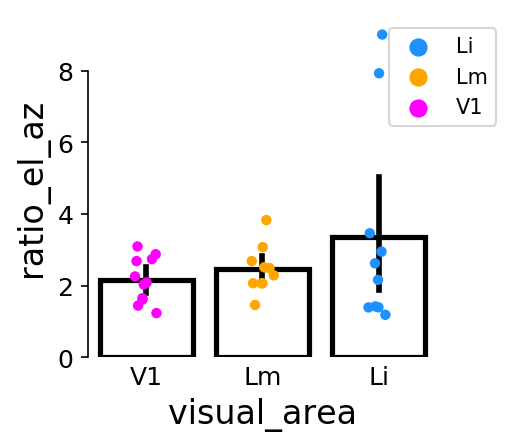

In [45]:
#currdf = projdf[~projdf['datakey'].isin(exclude_retinos)]
currdf = projdf.copy()

#currdf = projdf[projdf['datakey'].isin(include_retinos)]

rmags = pd.DataFrame({
    'ratio_el_az': [float(g[g['cond']=='el']['cortical_mag'].values/g[g['cond']=='az']['cortical_mag'].values) \
              for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])],
    'visual_area': [visual_area for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])],
    'datakey': [datakey for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])]})


fig, ax =pl.subplots(figsize=(3,3), dpi=dpi)
sns.stripplot(x='visual_area', y='ratio_el_az', hue='visual_area', data=rmags,
             palette=area_colors, order=visual_areas, ax=ax)

#if barplot:
sns.barplot("visual_area", 'ratio_el_az', data=rmags, ax=ax,
           hue=None, order=visual_areas, errcolor="k",
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
pl.legend(bbox_to_anchor=((1.2, 1)))
# rmags.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', fmt='%.1f', xytext=(10,0))


### Cortical mag, PAIRED

V1: (t-stat:-5.35, p=0.00)
Lm: (t-stat:-11.93, p=0.00)
Li: (t-stat:-3.64, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter', 'cortical_mag_paired-az-el_all-retino-dsets__R2-0.70_pixels_thr-0.003_manuallyfilter')


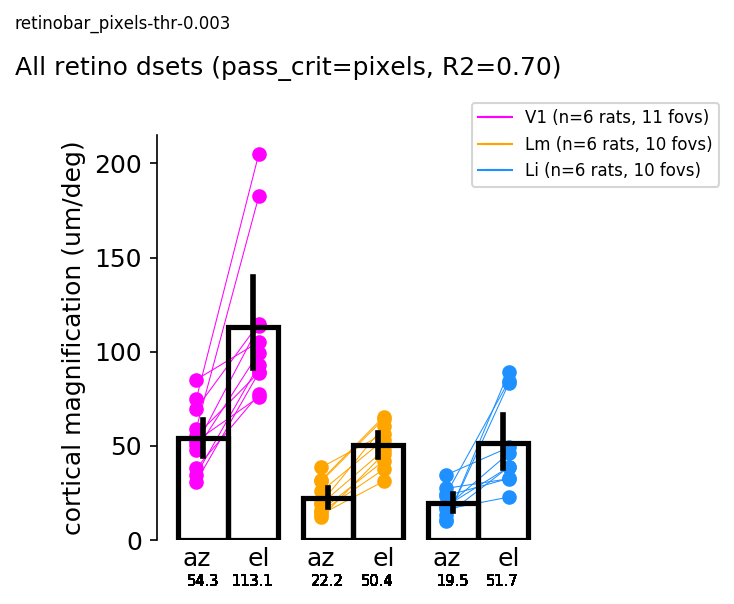

In [47]:
metric = 'cortical_mag'
#metric = 'abs_coef'
currdf = projdf.copy() # projdf[~projdf['datakey'].isin(exclude_retinos)]

fig = plot_pairwise_by_axis(currdf, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.1f', xytext=(0, -20))
pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
if metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)
else:
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)
    
fig.text(0, 0.9, 
         'All retino dsets (pass_crit=%s, R2=%.2f)' % (pass_criterion, retino_r2_thr), fontsize=12)
    
label_figure(fig, retino_dataid)

figname = '%s_paired-az-el_all-retino-dsets__R2-%.2f_%s_manuallyfilter' % (metric, retino_r2_thr, magthr_str)
pl.savefig(os.path.join(basedir, '%s.svg' % figname))
print(basedir, figname)

In [79]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

# Scatter

In [48]:
from pipeline.python.rois.utils import load_roi_coords

In [50]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

#     #### Split fx, fy for theta comp
#     r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
#     r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
#     r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

#     # Convert thetas to [-90, 90]
#     thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
#               else (t % np.pi) for t in r_df['theta'].values]
#     r_df['theta_c'] = thetas

    return r_df

In [51]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

## Filter RF datasets (e.g., drop_repeats)

In [53]:
#rf_filter_by = None # 'drop_repeats'
rf_filter_by = 'drop_repeats'

reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

rf_dataid = 'rfs_%s-%s' % (rf_filter_by, reliable_str)
print(rf_dataid)


rfs_drop_repeats-reliable


In [54]:
# Set data identifiers

#retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
#rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|%s|%s' % (fov_type, state, retino_dataid, rf_dataid)
print(data_id)


zoom2p0x|awake|retinobar_pixels-thr-0.003|rfs_drop_repeats-reliable


# Load cell positions (and RF info)

In [56]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)

print("Found saved position info:")

glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr
Found saved position info:


[]

In [57]:
# Load the one that has ALL rfs/rfs10 (just without repeat FOVs)
df_fpath = glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))[2]
print(df_fpath)

IndexError: list index out of range

In [61]:
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/fits_and_coords_drop_repeats_reliable.pkl


In [62]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            rf_df = pkl.load(f)
        if isinstance(rf_df, dict):
            rf_df = rf_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
True


In [66]:
if get_positions:
    # Get RF fit info first
    rf_df = get_rf_dataframe(filter_by=rf_filter_by, 
                     fit_thr=rf_fit_thr, traceid=traceid, fit_desc=rf_fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rf_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in rf_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rf_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(rf_df, f, protocol=pkl.HIGHEST_PROTOCOL)

droppin repeats
[filter_by=drop_repeats] Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Chec

In [69]:
rf_df.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,anisotropy,theta_Mm_c,aniso_index,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,0.580649,39.313922,32.229415,5.492987,-24.296039,-2.675288,JC076,7.0,20190502_JC076_fov1,rfs,...,0.099024,-0.790198,0.041688,0,248.886,108,418.818,220,553.982,928.714
1,0.543558,38.412704,28.843229,0.053140,-19.489468,0.470324,JC076,11.0,20190502_JC076_fov1,rfs,...,0.142284,0.053140,-0.127170,0,225.841,98,382.647,201,590.153,951.759
2,0.526974,26.547485,42.180811,4.307593,-20.445881,6.712333,JC076,14.0,20190502_JC076_fov1,rfs,...,0.227466,-0.404796,-0.048299,0,347.98,151,338.862,178,633.938,829.62
3,0.726948,36.533937,26.539191,6.021284,24.423551,4.300886,JC089,99.0,20190522_JC089_fov1,rfs,...,0.158463,-0.261901,-0.076405,1,695.959,302,603.479,317,369.321,481.641
4,0.582412,33.914768,29.864391,0.691663,4.513540,4.223902,JC089,130.0,20190522_JC089_fov1,rfs10,...,0.063506,0.691663,0.017505,1,838.838,364,786.236,413,186.564,338.762


In [144]:
# no_retino=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     if (projdf[projdf['datakey']==datakey].shape[0])==0:
#         no_retino.append((visual_area, datakey))
# for r in no_retino:
#     print r
    

# Get datasets with BOTH retino + rfs/rfs10 measured.
#### Also filter retino gradient df to only include dsets that have good fits (i.e., R2 > thr means retino direction well enough estimated or consistent enough to get a good projection)
NOTE:  TODO, check bad-fit retino dsets, since these may be split FOVs

In [82]:
retino_datakeys = gradient_df['datakey'].unique()
rf_datakeys = rf_df['datakey'].unique()
common_datakeys = np.intersect1d(gradient_df['datakey'].unique(), rf_df['datakey'].unique())

print("Retino: %i, RFs: %i, Common: %i" % (len(retino_datakeys), len(rf_datakeys), len(common_datakeys)))

Retino: 55, RFs: 40, Common: 34


In [85]:
# Get final RF dataframe
rfdf = rf_df[rf_df['datakey'].isin(common_datakeys)].copy()
print("RFs:")
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

# Get final RETINO dataframe
projdf = gradient_df[gradient_df['datakey'].isin(common_datakeys)].copy()
print("retinogradients:")
#tmp = projdf[~projdf['datakey'].isin(exclude_retinos)]
#projdf = tmp.copy()
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


RFs:
             datakey
visual_area         
Li                13
Lm                12
V1                 9
retinogradients:
             datakey
visual_area         
Li                13
Lm                12
V1                 9


In [92]:
retino_r2_thr = 0.75
retino_pass_crit='both'

if retino_pass_crit=='both':
    projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
else:
    projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) or (g[g['cond']=='el']['R2'].values > retino_r2_thr))])    
print("retinogradients (filt): %.2f, %s" % (retino_r2_thr, retino_pass_crit))
print(projdf_filtered[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

retinogradients (filt): 0.75, both
             datakey
visual_area         
Li                 6
Lm                 4
V1                 8


In [74]:
#filter_by, fit_str, magthr_str
figstr = '[%s_%s]' % (retino_dataid, rf_dataid)
figstr

'[retinobar_pixels-thr-0.003_rfs_drop_repeats-reliable]'

# Get projected ctx positions

In [87]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((datakey, exp), rd) in enumerate(rfdf.groupby(['datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))
        
    #retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
    p_df = projdf[projdf['datakey']==datakey]
    assert len(p_df['fpath'].unique())==1, "No unique retino path found: %s" % str(p_df['fpath'].unique())
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])

1 of 40 gradient result files loaded.
11 of 40 gradient result files loaded.
21 of 40 gradient result files loaded.
31 of 40 gradient result files loaded.
40 of 40 gradient result files loaded.


In [88]:
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                13
Lm                12
V1                 9
             datakey
visual_area         
Li                13
Lm                12
V1                 9


# Aggregate scatter metrics

In [90]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)



In [91]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [103]:
rfs_[rfs_['cell'].isin(rf_cell_ids[keep_ixs])]

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,aniso_index,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,ml_proj,ap_proj
609,0.605929,33.963037,17.889245,0.182185,41.435366,19.975618,JC117,34.0,20191111_JC117_fov1,rfs10,...,-0.197664,8,124.443,54,180.853,95,791.947,1053.16,660.585,818.871
610,0.755927,17.482925,28.553416,4.934087,42.880454,19.741225,JC117,38.0,20191111_JC117_fov1,rfs10,...,-0.134719,8,170.533,74,203.698,107,769.102,1007.07,643.405,780.049
611,0.727325,31.303208,13.596721,3.431207,41.795137,19.090330,JC117,57.0,20191111_JC117_fov1,rfs10,...,-0.169113,8,135.966,59,306.499,161,666.301,1041.63,537.213,839.471
612,0.593732,34.902371,40.671315,6.057733,32.173092,12.630480,JC117,58.0,20191111_JC117_fov1,rfs10,...,0.072472,8,179.751,78,298.884,157,673.916,997.849,549.999,795.182
613,0.543449,42.163811,24.311943,0.291715,34.054144,17.409110,JC117,89.0,20191111_JC117_fov1,rfs10,...,-0.114082,8,246.582,107,405.492,213,567.308,931.018,452.13,757.458
614,0.707866,34.524689,22.767085,6.224191,31.720748,17.696888,JC117,119.0,20191111_JC117_fov1,rfs10,...,-0.181023,8,165.924,72,687.242,361,285.558,1011.68,162.767,906.691
615,0.713740,46.027209,22.260759,0.384605,30.775235,15.965499,JC117,121.0,20191111_JC117_fov1,rfs10,...,-0.086874,8,191.274,83,651.072,342,321.728,986.326,201.704,873.025
616,0.708392,36.830507,20.672131,0.327673,32.583351,16.186757,JC117,124.0,20191111_JC117_fov1,rfs10,...,-0.100126,8,244.277,106,732.932,385,239.868,933.323,126.756,842.426
617,0.809842,36.510613,29.254619,0.193318,30.177386,15.399587,JC117,127.0,20191111_JC117_fov1,rfs10,...,-0.067939,8,195.883,85,761.487,400,211.313,981.717,92.6282,896.465
618,0.653818,43.499259,23.807867,0.531044,24.153241,16.573287,JC117,128.0,20191111_JC117_fov1,rfs10,...,0.003765,8,218.928,95,799.562,420,173.238,958.672,57.5765,883.789


# scatdf:  filter gradient results, only include if good fits

In [104]:
#rfname = 'rfs10'
retino_r2_thr=0.75
min_ncells=5
retino_pass_crit='both' 

if retino_pass_crit=='both':
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2_thr) \
                                and (g[g['cond']=='el']['R2'].values>retino_r2_thr))])
else:
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2_thr) \
                                or (g[g['cond']=='el']['R2'].values>retino_r2_thr))])

curr_gradients = filtproj.copy()

not_enough_cells_fit = []
bad_fits = []
d_list = []

for (visual_area, datakey, rfname), rfs_ in rfdf.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:
    print("[%s] %s (%s)" % (visual_area, datakey, rfname))
    
    if rfs_.shape[0] < min_ncells:
        print("--- too few cells (min%i), %s" % (min_ncells, datakey))
        not_enough_cells_fit.append(datakey)
        continue
    if datakey not in curr_gradients['datakey'].unique():
        print("--- bad gradient, %s" % datakey)
        continue

    # Get retino gradient
    #retinorun = curr_gradients[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()
    ret_ = curr_gradients[curr_gradients['datakey']==datakey].copy()
    
    for cond, ret_cond in ret_.groupby(['cond']):
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'
        max_degrees = screen['azimuth_deg']*2. if cond=='az' else screen['altitude_deg']*2.
        max_fovdist = 1177*2. if cond=='ap' else 972.*2.
        
        # Get RF fit info
        proj_locs = np.array(rfs_['%s_proj' % xname].values)
        rf_locs = np.array(rfs_[yname].values)
        rf_cell_ids = rfs_['cell'].values
        
        # Get dist to line:
        slope = float(ret_cond['coefficient'])
        intercept = float(ret_cond['intercept'])
        r2 = float(ret_cond['R2'])
        predicted_rf_locs = slope*proj_locs + intercept
        
        # Calculate DEG and DIST scattered
        deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
        deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
        dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
        dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
        keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
        n_pts = len(keep_ixs)
        if (n_pts)==0:
            bad_fits.append((datakey, cond))
            continue
        print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
        print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
        assert len(rf_cell_ids)==len(deg_sc)
            
        if any(np.isnan(dist_sc)):
            print(visual_area, datakey, r2)
        if any(np.isnan(deg_sc)):
            print(visual_area, datakey, r2)
        tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                           'deg_scatter': deg_sc[keep_ixs],
                           'dist_scatter': dist_sc[keep_ixs],
                           'measured_rf': rf_locs[keep_ixs],
                           'predicted_rf': predicted_rf_locs[keep_ixs],
                           'measured_loc': proj_locs[keep_ixs],
                           'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                           'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                           'axis': [cond for _ in np.arange(0, n_pts)],
                           'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                           'datakey': [datakey for _ in np.arange(0, n_pts)],
                           'rfname': [rfname for _ in np.arange(0, n_pts)]
                     })
        
        d_ = pd.merge(tmpd, rfs_[rfs_['cell'].isin(rf_cell_ids[keep_ixs])].reset_index(drop=True))
        
        d_list.append(d_)
scatdf = pd.concat(d_list, axis=0)
print(scatdf.shape)
scatdf.head()


[Li] 20190522_JC089_fov1 (rfs)
--- too few cells (min5), 20190522_JC089_fov1
[Li] 20190522_JC089_fov1 (rfs10)
--- too few cells (min5), 20190522_JC089_fov1
[Li] 20190527_JC092_fov3 (rfs10)
... (az) deg: 21 of 21 in bounds
... (az) dist: 21 of 21 in bounds
... (el) deg: 21 of 21 in bounds
... (el) dist: 21 of 21 in bounds
[Li] 20190528_JC092_fov1 (rfs10)
--- too few cells (min5), 20190528_JC092_fov1
[Li] 20190605_JC090_fov1 (rfs10)
... (az) deg: 7 of 7 in bounds
... (az) dist: 7 of 7 in bounds
... (el) deg: 7 of 7 in bounds
... (el) dist: 7 of 7 in bounds
[Li] 20190607_JC091_fov1 (rfs10)
--- bad gradient, 20190607_JC091_fov1
[Li] 20190612_JC099_fov1 (rfs10)
... (az) deg: 22 of 22 in bounds
... (az) dist: 22 of 22 in bounds
... (el) deg: 22 of 22 in bounds
... (el) dist: 22 of 22 in bounds
[Li] 20190614_JC091_fov1 (rfs10)
--- bad gradient, 20190614_JC091_fov1
[Li] 20190617_JC099_fov1 (rfs10)
... (az) deg: 5 of 5 in bounds
... (az) dist: 5 of 5 in bounds
... (el) deg: 5 of 5 in bounds
...

,axis,cell,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,...,aniso_index,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,ml_proj,ap_proj
0,az,1.0,20190527_JC092_fov3,9.319485,92.329838,629.847,9.132846,537.517115,18.4523,0.979097,...,0.038279,8,200.492,87,415.011,218,557.789,977.108,629.847,338.63
1,az,2.0,20190527_JC092_fov3,1.318961,13.067188,652.465,19.416383,639.397991,20.7353,0.979097,...,0.053270,8,177.447,77,394.07,207,578.73,1000.15,652.465,341.33
2,az,4.0,20190527_JC092_fov3,4.700516,46.568873,620.84,12.842649,574.270809,17.5432,0.979097,...,0.140134,8,269.627,117,418.818,220,553.982,907.973,620.84,290.459
3,az,5.0,20190527_JC092_fov3,5.218544,51.701069,605.702,10.796706,554.001279,16.0152,0.979097,...,-0.001147,8,168.229,73,441.663,232,531.137,1009.37,605.702,380.412
4,az,12.0,20190527_JC092_fov3,5.701426,56.485072,738.373,23.705192,681.888007,29.4066,0.979097,...,-0.066365,8,246.582,107,302.691,159,670.109,931.018,738.373,228.53


In [94]:
len(rfs_['cell']), len(deg_sc)

(16, 16)

In [95]:
print("Not enough cells passed RF fit:", not_enough_cells_fit)
print("Bad fits for predicted pos/rf:", bad_fits)

('Not enough cells passed RF fit:', ['20190522_JC089_fov1', '20190522_JC089_fov1', '20190528_JC092_fov1', '20191003_JC111_fov1', '20191111_JC120_fov1', '20190423_JC076_fov1', '20190509_JC078_fov1', '20190517_JC083_fov1', '20190618_JC097_fov1', '20191111_JC117_fov2'])
('Bad fits for predicted pos/rf:', [])


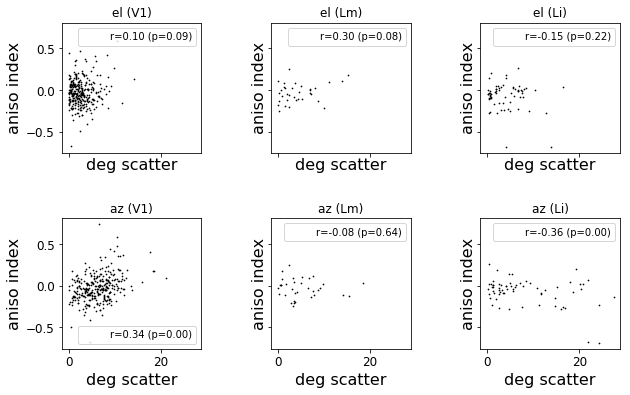

In [128]:
fig, axn = pl.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))

for ai, ((visual_area, cond), d_) in enumerate(scatdf.groupby(['axis', 'visual_area'])):
    ax = axn.flat[5-ai]
    
    xv =d_['deg_scatter']
    yv = d_['aniso_index']
    ax.scatter(xv, yv, marker='.', s=2, c='k', label=None)
    ax.set_ylabel('aniso index')
    ax.set_xlabel('deg scatter')
    
    ax.set_title('%s (%s)' % (visual_area, cond))
    
    pearsonr, pearsonp = spstats.pearsonr(xv, yv)
    ax.plot(0, 0, alpha=0, label='r=%.2f (p=%.2f)' % (pearsonr, pearsonp))
    ax.legend()
    
pl.subplots_adjust(wspace=0.5, hspace=0.5)

In [100]:
rfdf.shape

(598, 37)

0.75


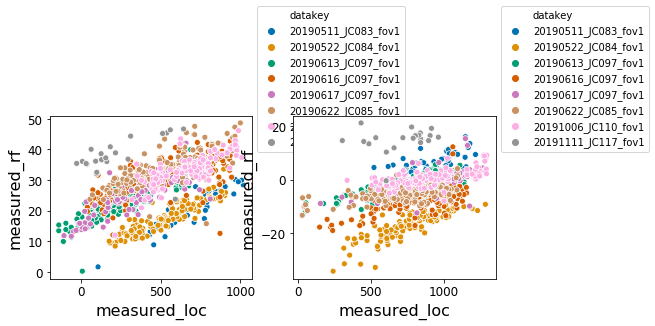

In [104]:
print(retino_r2_thr)
plotdf = scatdf[scatdf['retino_R2']>retino_r2_thr].copy()
sns.set_palette('colorblind')
fig, axn = pl.subplots(1,2, figsize=(8,3))
visual_area = 'V1'

vdf = plotdf[plotdf['visual_area']==visual_area]

for ax, (cond, vdf_ax) in zip(axn.flat, vdf.groupby(['axis'])):

    sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                    hue='datakey')
    
    ax.legend(bbox_to_anchor=(1., 1.7))

In [96]:
scatdf['retino_R2'].min()

0.75145100173045687

# Plot Deg/Dist (color by RF exp)

In [97]:
#retino_thr = 0.9
#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

mean_scatter = scatdf.groupby(['visual_area', 'datakey', 'axis', 'rfname']).mean().reset_index()
mean_scatter.head()

print(mean_scatter.shape)
#print(mean_values[mean_values['retino_R2']>0.9].shape)
#mean_scatter

(40, 10)


Text(0.5,0.98,u'RF vs retino gradient (RF: drop_repeats, Retino: R2=0.75, both)')

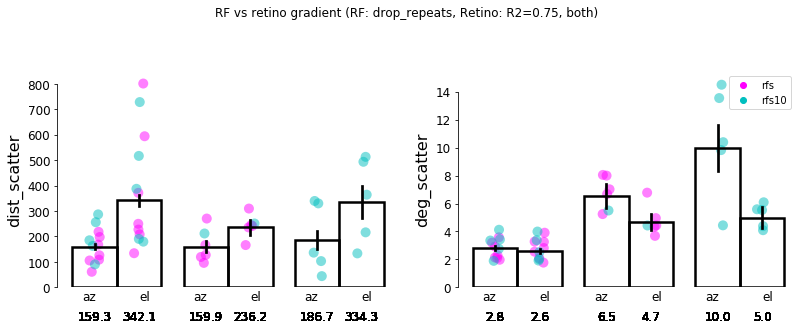

In [106]:
plot_cells=False
rfcolors = ['magenta', 'c']
rfnames = ['rfs', 'rfs10']

plot_str = '' if plot_cells else 'fovmeans'

fig, axn = pl.subplots(1,2, figsize=(12,5))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):

    sns.barplot("visual_area", plotter, data=scatdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)
    
    # plot fov means (color by rfs or rfs10)
    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs'], 
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[0], 'az': rfcolors[0]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    ax.legend_.remove()

    scatdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f', fontcolor='k', xytext=(0, -30))
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

lines = [Line2D([0], [0], color=c, linewidth=0, marker='o') for c in rfcolors]
ax.legend(lines, rfnames)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.95, bottom=0.2, top=0.8)  
fig.suptitle('RF vs retino gradient (RF: %s, Retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2_thr, retino_pass_crit))

# label_figure(fig, data_id)
# figname = 'scatter_avg-by-fov_RFvRF10__R2-%.2f-%s__%s' % (retino_r2_thr, retino_pass_crit, figstr )
# pl.savefig(os.path.join(gradient_dir, '%s.png' % figname))
# print(gradient_dir, figname)

## Plot deg/dist separately for RFs and RF10

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'scatter_split-RFvRF10__R2-0.75-both__[retinobar_pixels-thr-0.003_rfs_drop_repeats-reliable]2')


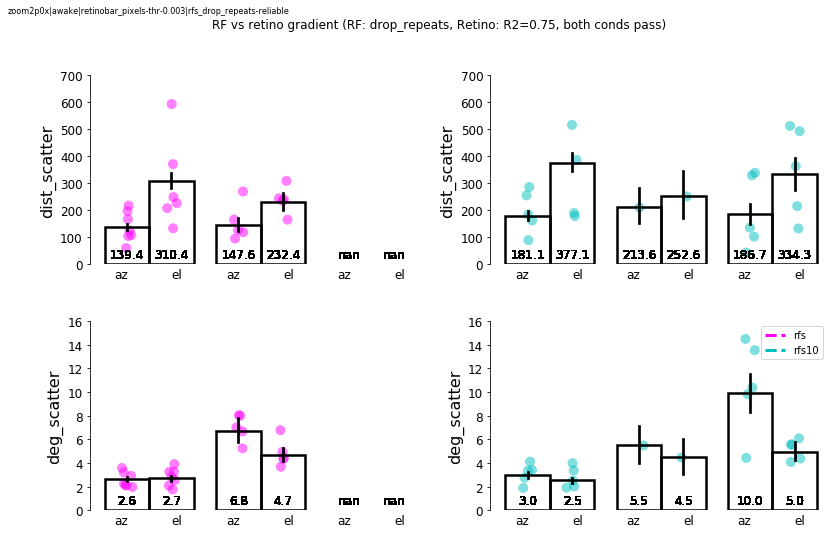

In [107]:
fig, axn = pl.subplots(2,2, figsize=(12,8))
for ai, plotter in enumerate( ['dist_scatter', 'deg_scatter']):
    for ci, (currcolor, currname) in enumerate(zip(rfcolors, rfnames)):
        ax = axn[ai, ci]
        
        axdf = scatdf[scatdf['rfname']==currname].copy()
        meandf = axdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

        sns.barplot("visual_area", plotter, data=axdf, ax=ax,
                   hue='axis', order=visual_areas, errcolor="k",
                   edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
        change_width(ax, .4)

        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf, #mean_scatter[mean_scatter['rfname']==currname], 
                      dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                     palette={'el': currcolor, 'az': currcolor}, alpha=0.5, order=['V1', 'Lm', 'Li'])
        ax.legend_.remove()
        axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f') # xytext=(0, -20))
        rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
        if ai==0:
            ax.set_ylim([0, 700])
        else:
            ax.set_ylim([0, 16])

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
fig.suptitle('RF vs retino gradient (RF: %s, Retino: R2=%.2f, %s conds pass)' % (rf_filter_by, retino_r2_thr, retino_pass_crit))

label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.2, hspace=0.3, left=0.1, right=0.95)  

figname = 'scatter_split-RFvRF10__R2-%.2f-%s__%s2' % (retino_r2_thr, retino_pass_crit, figstr )
pl.savefig(os.path.join(gradient_dir, '%s.png' % figname))
print(gradient_dir, figname)

#### Plot for RFs 

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'deg-dist-scatter_rfs_drop_repeats__retino-R2-0.75-both')


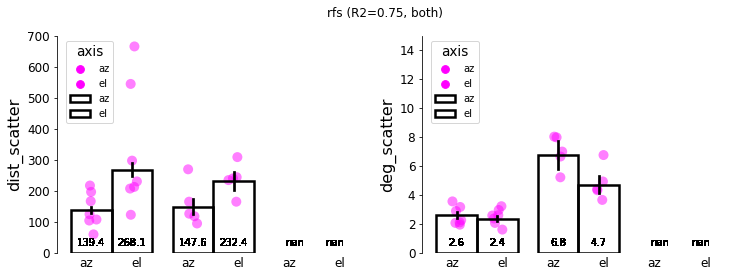

In [70]:
rfname = rfnames[0]
plotdf = scatdf[scatdf['rfname']==rfname]
meandf = plotdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, hue='axis', data=plotdf, ax=ax,
               order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf,
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[0], 'az': rfcolors[0]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    #ax.legend_.remove()
    
axn[0].set_ylim([0, 700])
axn[1].set_ylim([0, 15])

pl.suptitle('%s (R2=%.2f, %s)'  % (rfname, retino_r2_thr, retino_pass_crit))
figname = 'deg-dist-scatter_%s_%s__retino-R2-%.2f-%s' % (rfname, rf_filter_by, retino_r2_thr, retino_pass_crit)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)

#### Plot for RFs10

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'deg-dist-scatter_rfs10_drop_repeats__retino-R2-0.75-both')


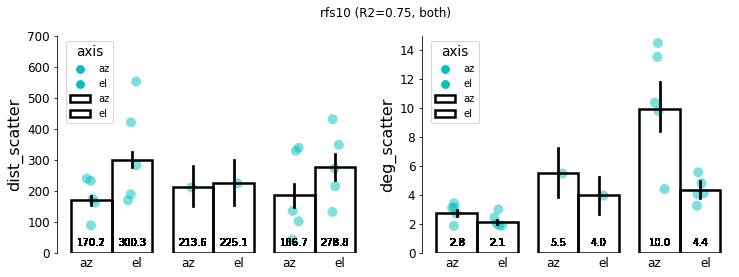

In [72]:
rfname = rfnames[1]
plotdf = scatdf[scatdf['rfname']==rfname]
meandf = plotdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, hue='axis', data=plotdf, ax=ax,
               order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf,
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

axn[0].set_ylim([0, 700])
axn[1].set_ylim([0, 15])

pl.suptitle(rfname)
pl.suptitle('%s (R2=%.2f, %s)'  % (rfname, retino_r2_thr, retino_pass_crit))
figname = 'deg-dist-scatter_%s_%s__retino-R2-%.2f-%s' % (rfname, rf_filter_by, retino_r2_thr, retino_pass_crit)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)

## Compare where both RFs + RFs10 collected

In [66]:
bothrfs = pd.concat([g for v, g in scatdf.groupby(['visual_area', 'datakey']) \
                             if 'rfs' in g['rfname'].values and 'rfs10' in g['rfname'].values])
bothrfs.shape


(1400, 12)

In [67]:
meanboth = bothrfs.groupby(['visual_area', 'datakey', 'rfname', 'axis']).mean().reset_index().sort_values(by='datakey')

meanboth['animalid'] = [s.split('_')[1] for s in meanboth['datakey']]
meanboth['session'] = [s.split('_')[0] for s in meanboth['datakey']]
meanboth['fov'] = [s.split('_')[2] for s in meanboth['datakey']]


In [68]:
meanboth

,visual_area,datakey,rfname,axis,cell,deg_scatter,dist_scatter,measured_rf,predicted_loc,retino_R2,animalid,session,fov
4,V1,20190613_JC097_fov1,rfs,az,100.238806,2.284635,108.707695,21.505552,177.767102,0.929008,JC097,20190613,fov1
5,V1,20190613_JC097_fov1,rfs,el,100.238806,2.096008,208.400985,-1.696596,921.960363,0.966632,JC097,20190613,fov1
6,V1,20190613_JC097_fov1,rfs10,az,110.112150,1.894361,90.137643,22.868336,242.611174,0.929008,JC097,20190613,fov1
7,V1,20190613_JC097_fov1,rfs10,el,110.112150,1.914386,190.342774,-2.717231,820.481140,0.966632,JC097,20190613,fov1
9,V1,20190616_JC097_fov1,rfs,el,201.792079,2.401976,213.660558,-5.698412,1045.325373,0.936202,JC097,20190616,fov1
11,V1,20190616_JC097_fov1,rfs10,el,203.861538,1.917581,170.572700,-7.819567,856.644361,0.936202,JC097,20190616,fov1
10,V1,20190616_JC097_fov1,rfs10,az,203.861538,3.166921,174.852600,31.167543,407.188630,0.878668,JC097,20190616,fov1
8,V1,20190616_JC097_fov1,rfs,az,199.843137,3.580395,197.681435,30.267266,357.482412,0.878668,JC097,20190616,fov1
0,Lm,20190618_JC097_fov1,rfs,az,119.500000,7.017212,270.376137,31.721507,-234.253751,0.955981,JC097,20190618,fov1
2,Lm,20190618_JC097_fov1,rfs10,az,110.357143,5.544424,213.628984,29.404789,-323.517866,0.955981,JC097,20190618,fov1


V1: (t-stat:-0.03, p=0.98)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:-0.19, p=0.86)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.69, p=0.19)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.29, p=0.29)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)


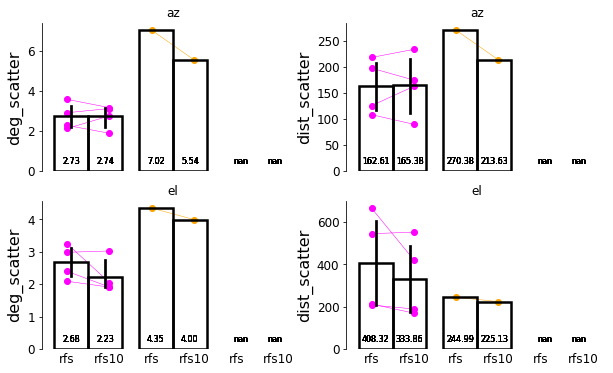

In [69]:
c1='rfs'
c2='rfs10'
# fig = plot_pairwise_by_axis(meanboth[meanboth['axis']=='az'], curr_metric='deg_scatter', compare_var='rfname',
#                             c1='rfs', c2='rfs10', legend=0, 
#                            area_colors=area_colors, fontsize=6, fontcolor='k')
fig, axn = pl.subplots(2,2, figsize=(10,6), sharex=True, sharey=False)
for ri, (axname, axdf) in enumerate(meanboth.groupby(['axis'])):
    ax = axn[ri, 0]
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(axdf, curr_metric='deg_scatter', ax=ax,
                                                c1=c1, c2=c2, compare_var='rfname')
    axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
    ax.set_title(axname)
    
    
    ax = axn[ri, 1]
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(axdf, curr_metric='dist_scatter', ax=ax,
                                                c1=c1, c2=c2, compare_var='rfname')
    axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
    ax.set_title(axname)

## Create joint distN of DEG/DIST scatter

In [290]:
scatterfov_dir = os.path.join(dst_dir, 'example_scatter_fovs_%s' % rf_filter_by)
if not os.path.exists(scatterfov_dir):
    os.makedirs(scatterfov_dir)
print(scatterfov_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/example_scatter_fovs_drop_repeats


((80, 11), (2, 18))
((34, 11), (2, 18))
((80, 11), (2, 18))
((22, 11), (2, 18))
((24, 11), (2, 18))
((38, 11), (2, 18))
((46, 11), (2, 18))
((73, 11), (2, 18))
((114, 11), (2, 18))
((28, 11), (2, 18))
((55, 11), (2, 18))
((18, 11), (2, 18))
((87, 11), (2, 18))
((248, 11), (2, 18))
((134, 11), (2, 18))
((214, 11), (2, 18))
((203, 11), (2, 18))
((260, 11), (2, 18))
((177, 11), (2, 18))
((47, 11), (2, 18))
((214, 11), (2, 18))
((92, 11), (2, 18))
((153, 11), (2, 18))
((38, 11), (2, 18))


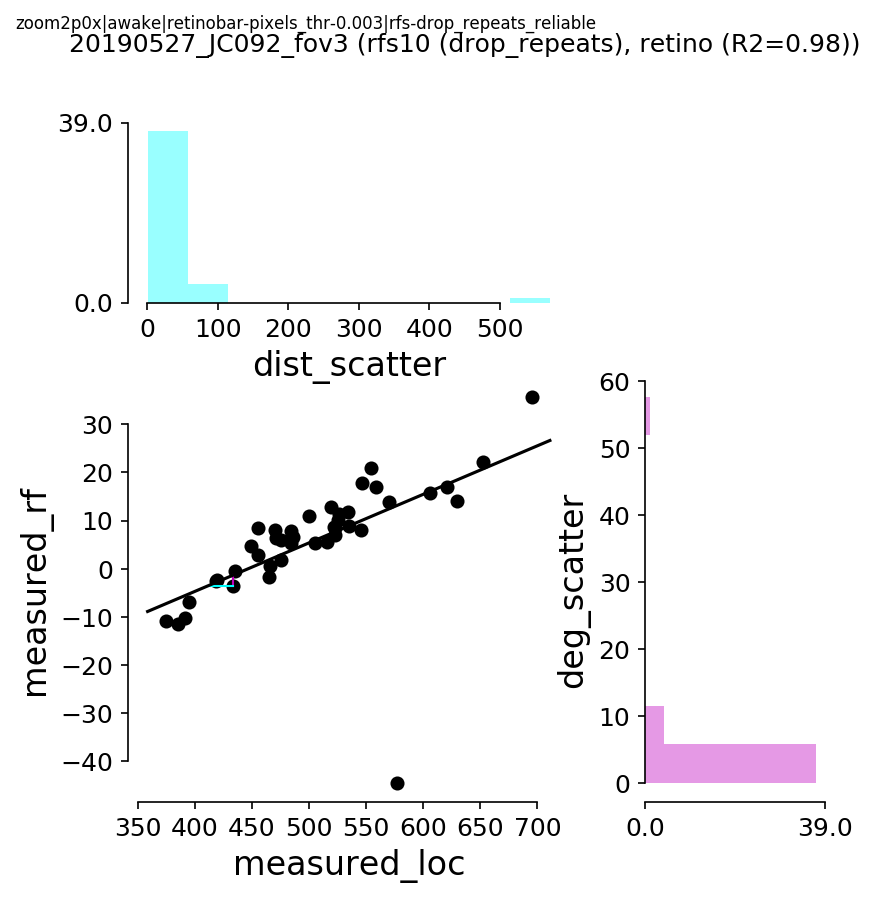

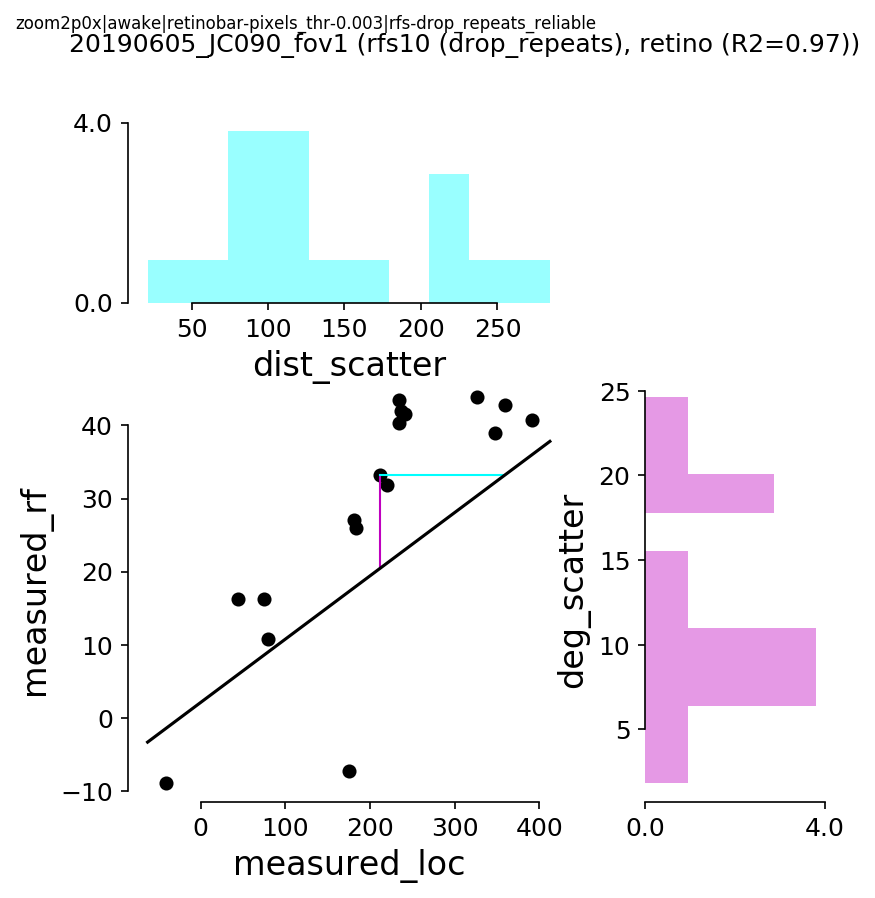

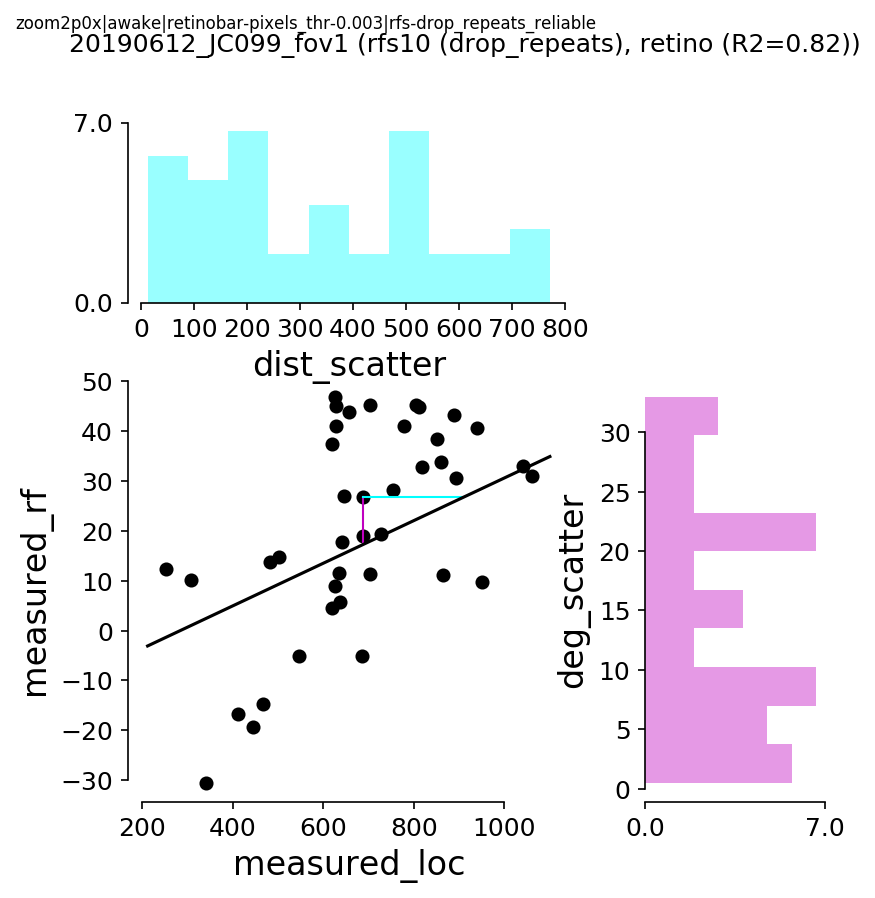

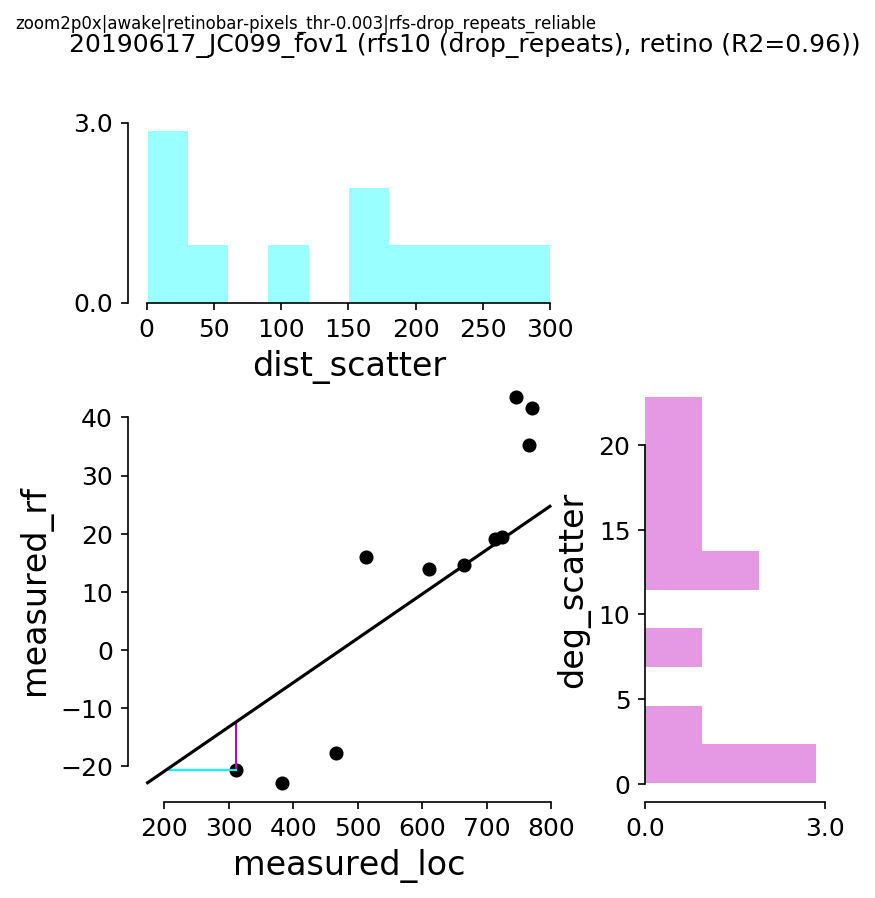

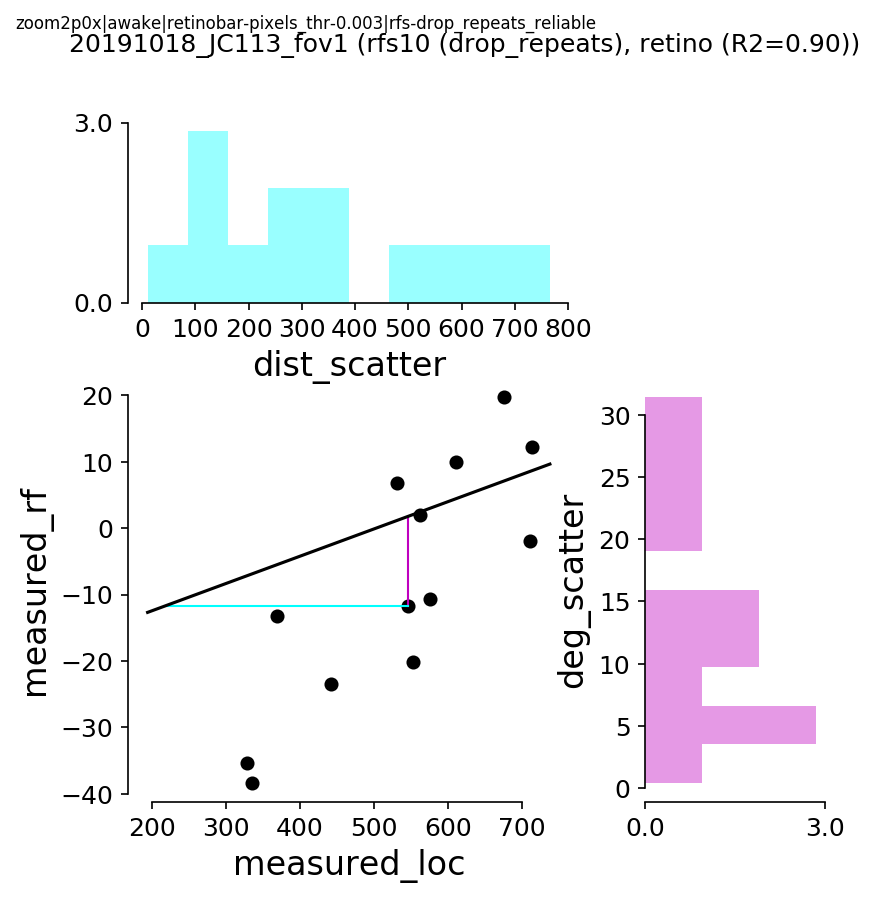

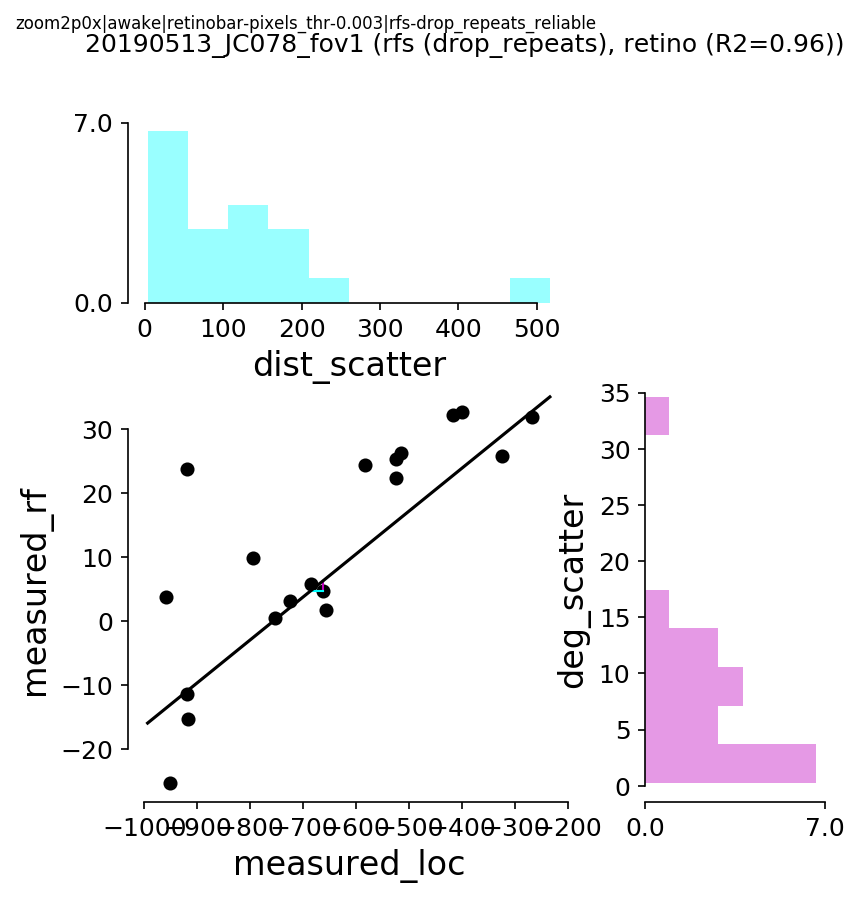

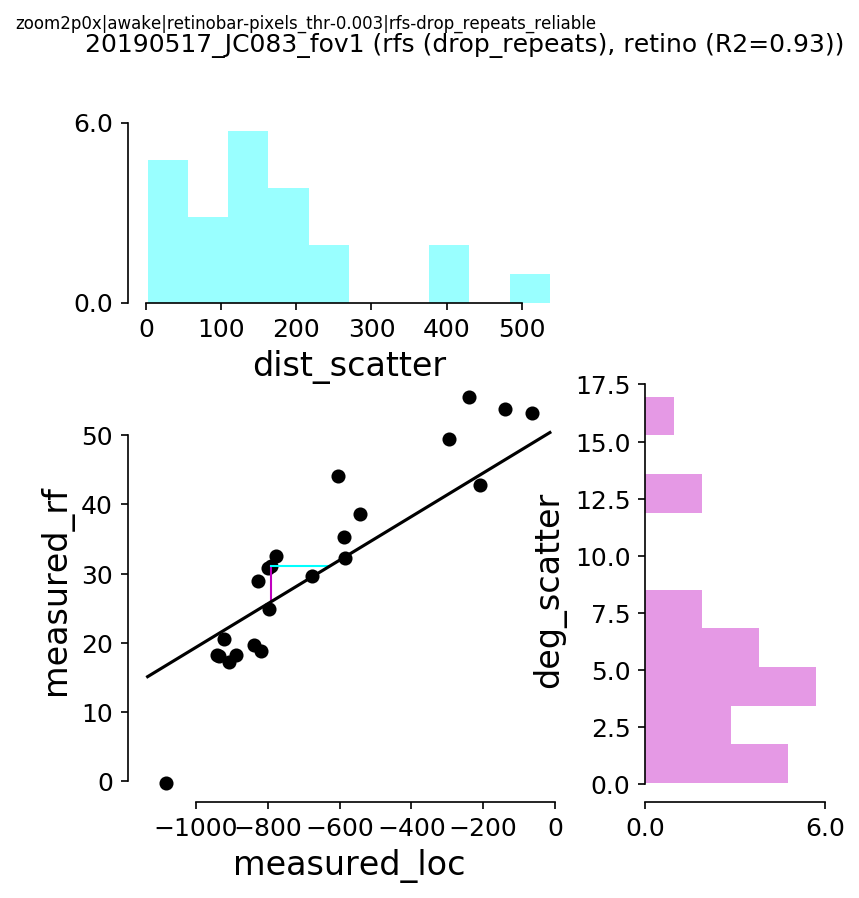

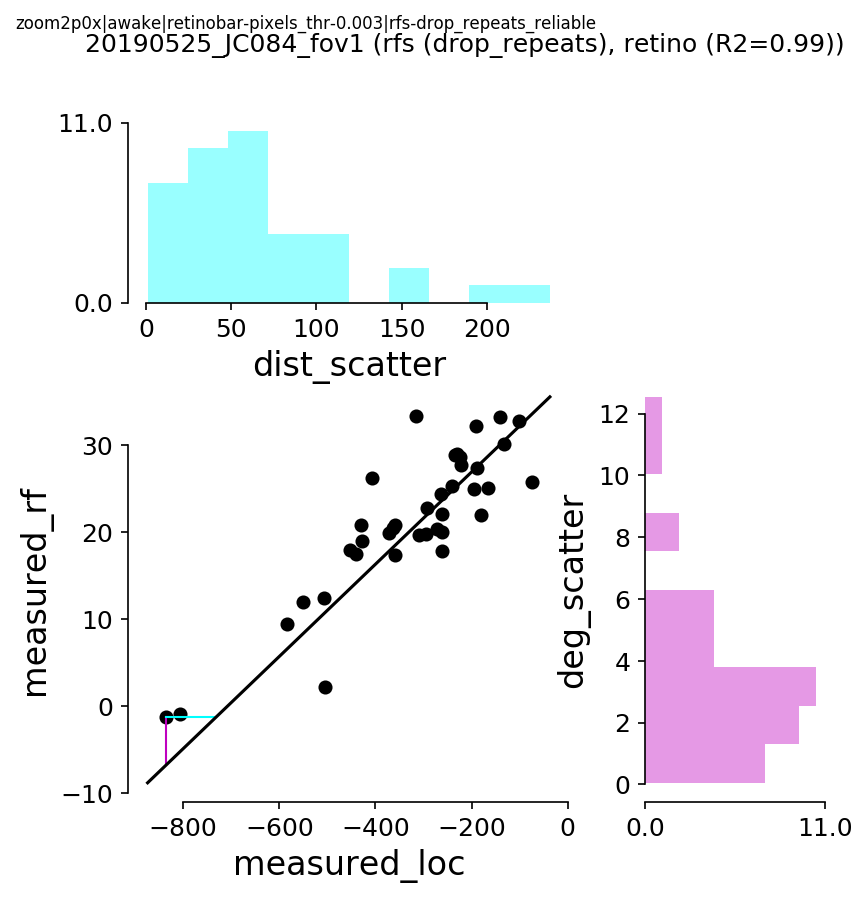

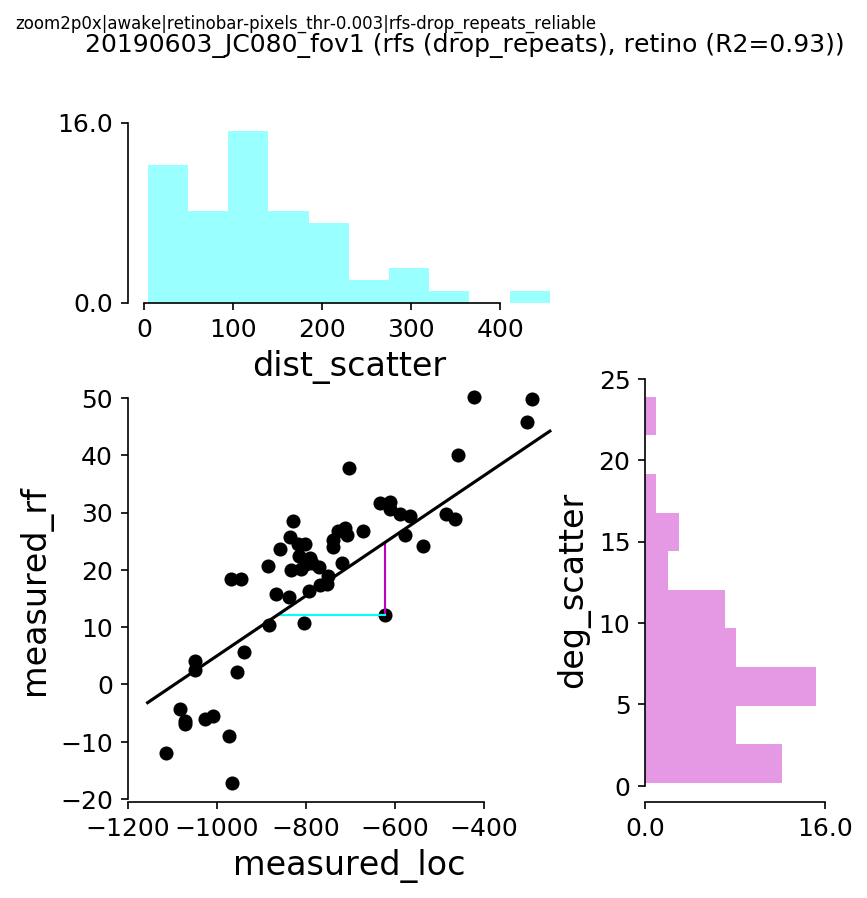

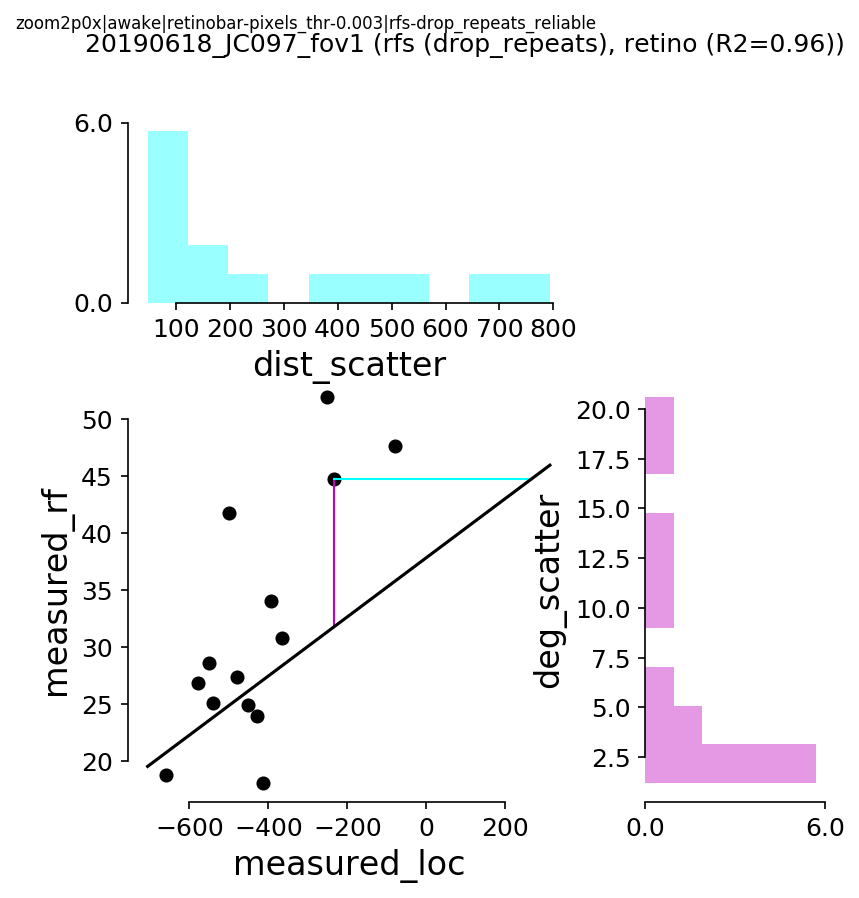

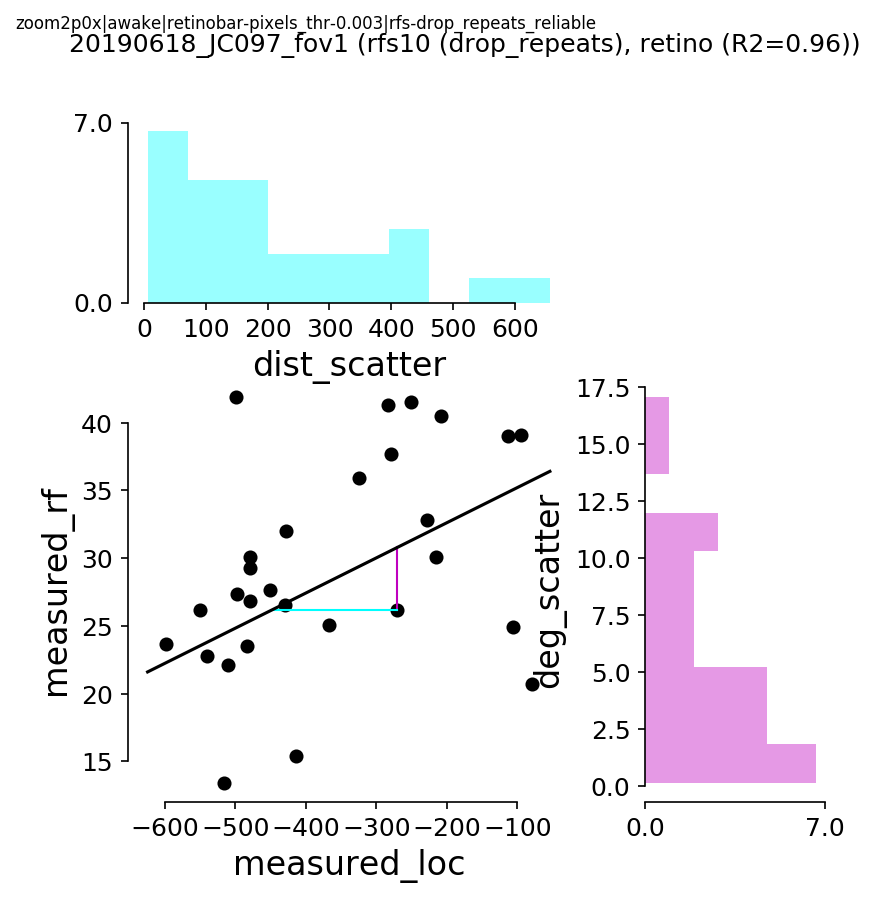

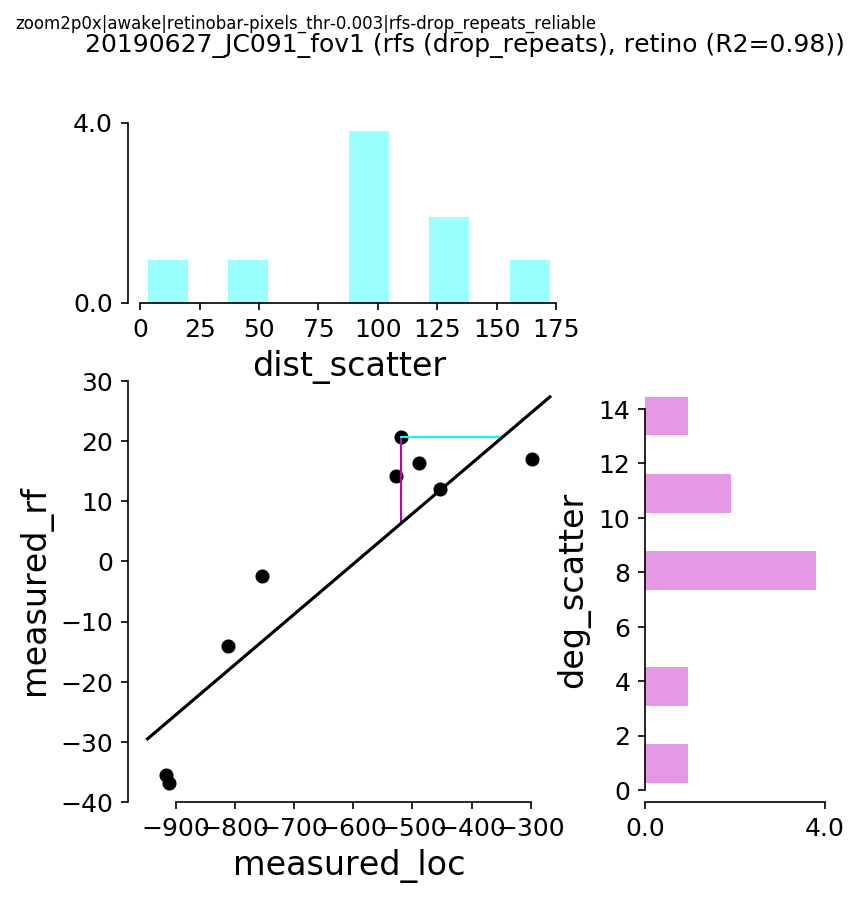

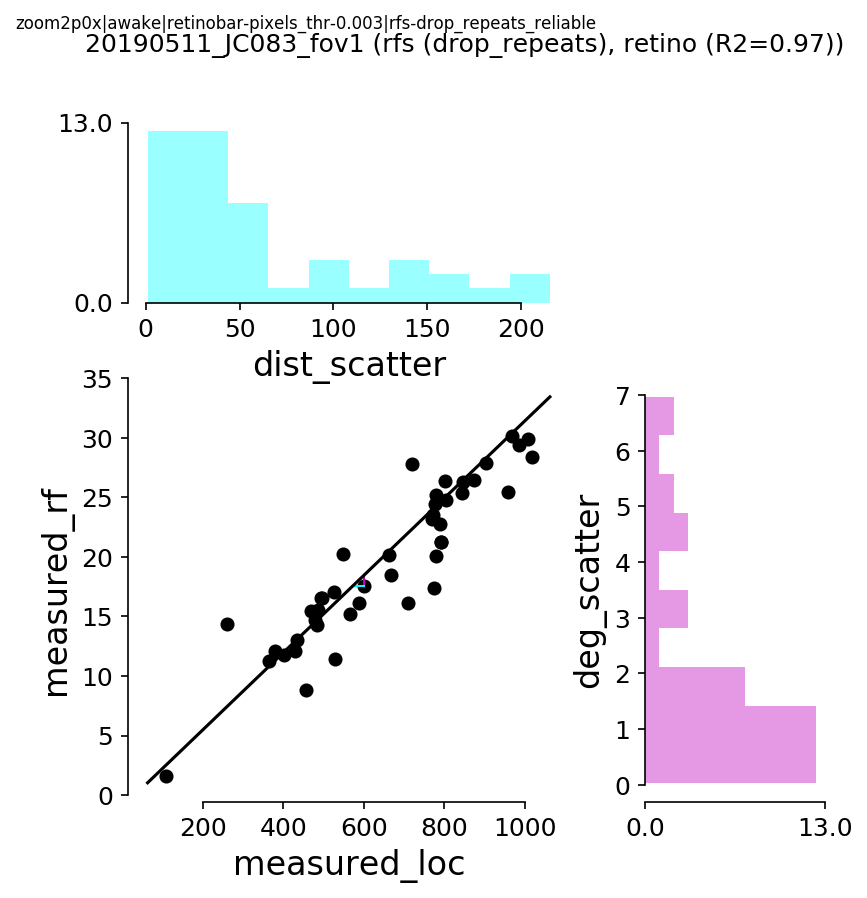

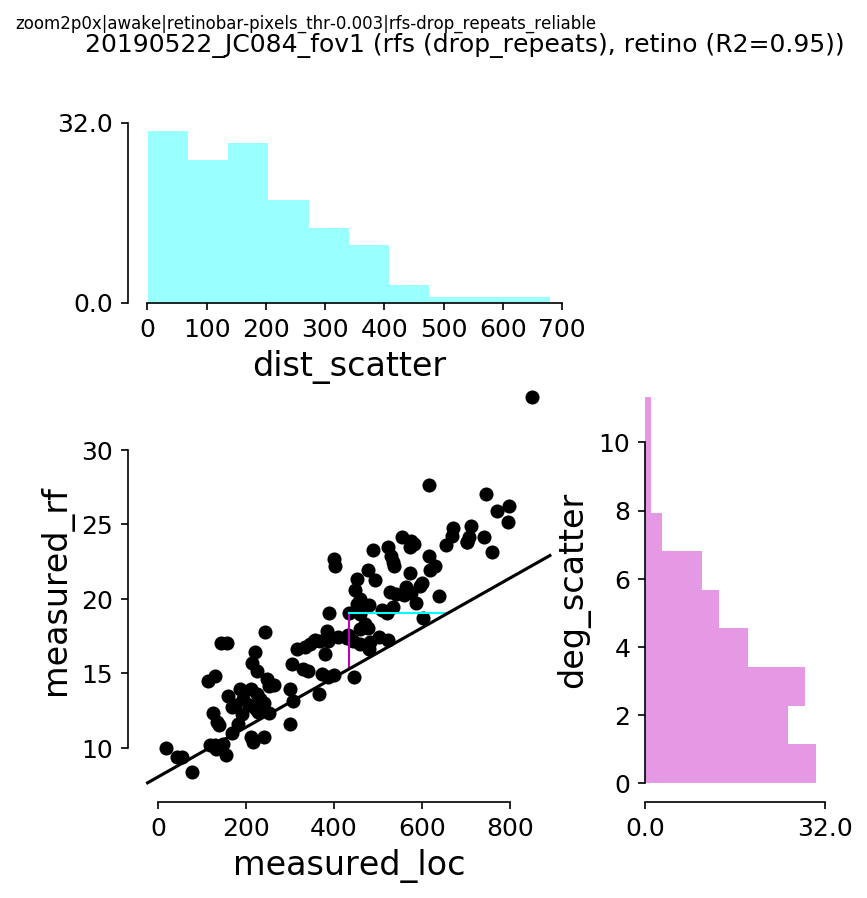

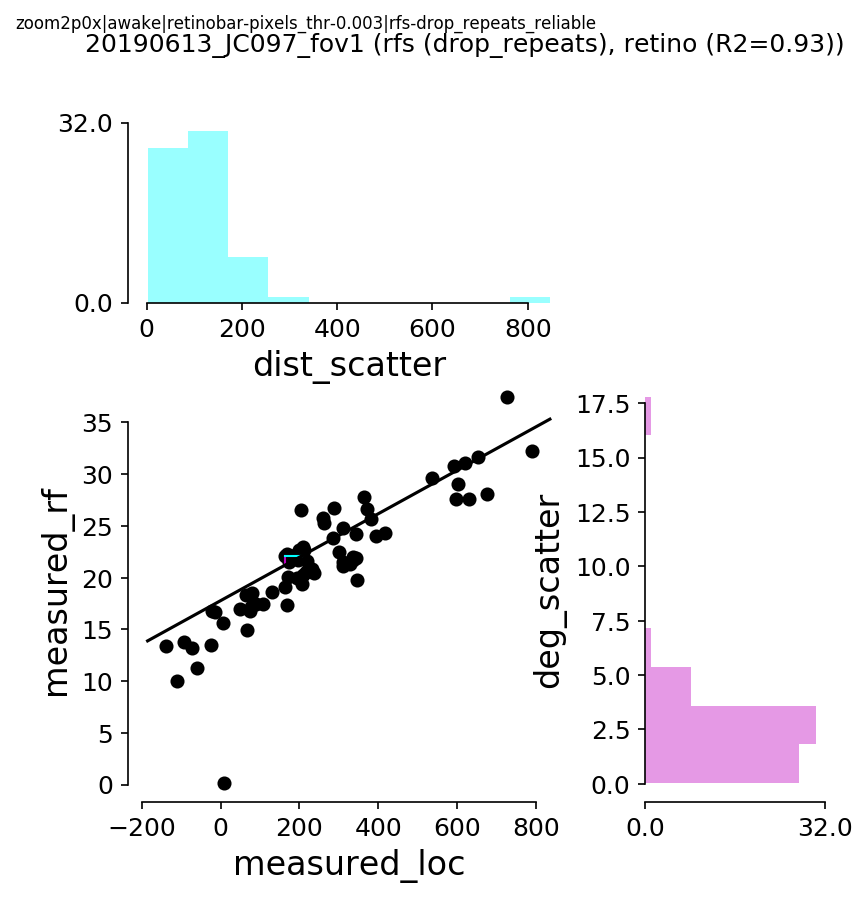

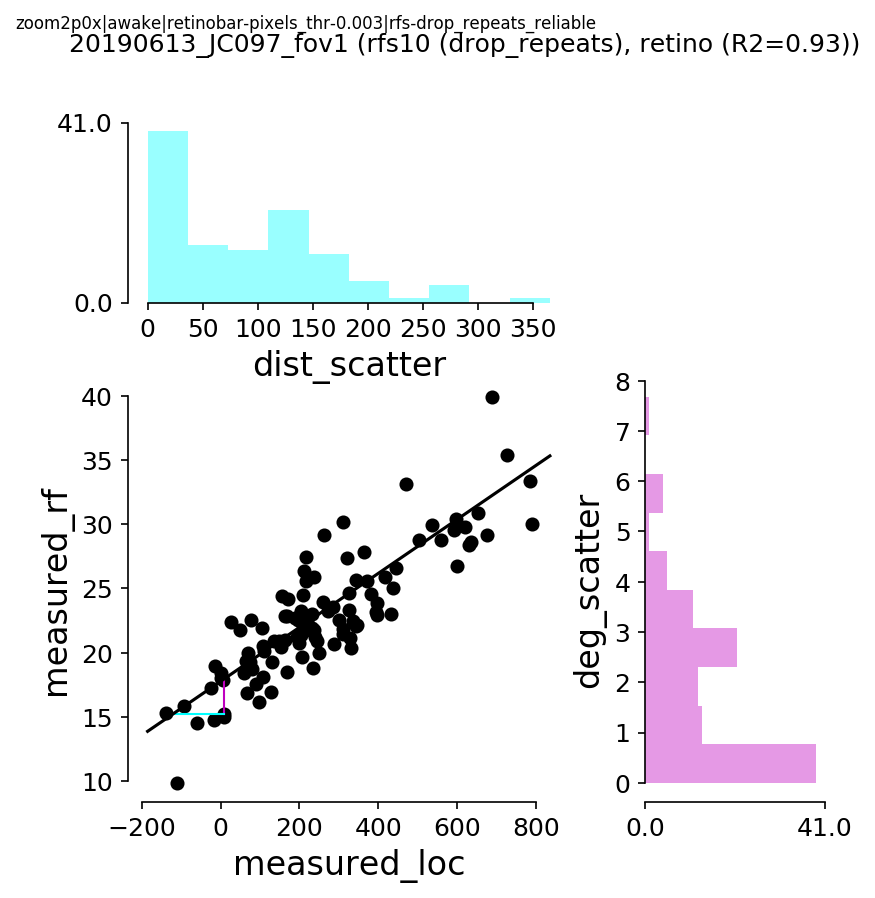

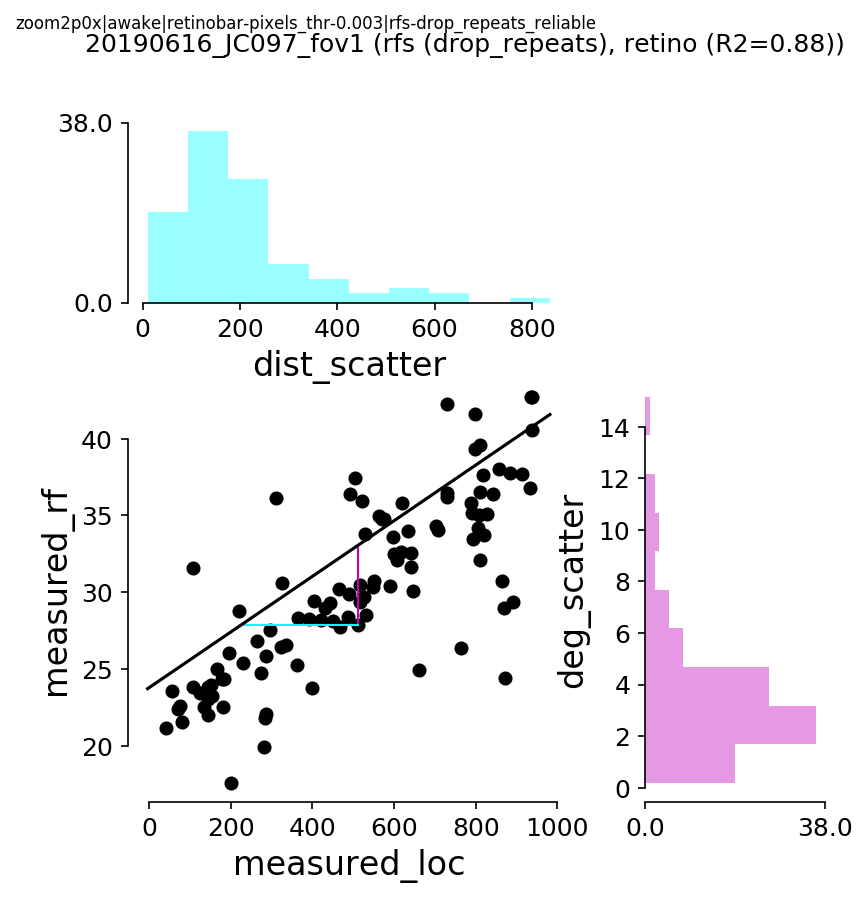

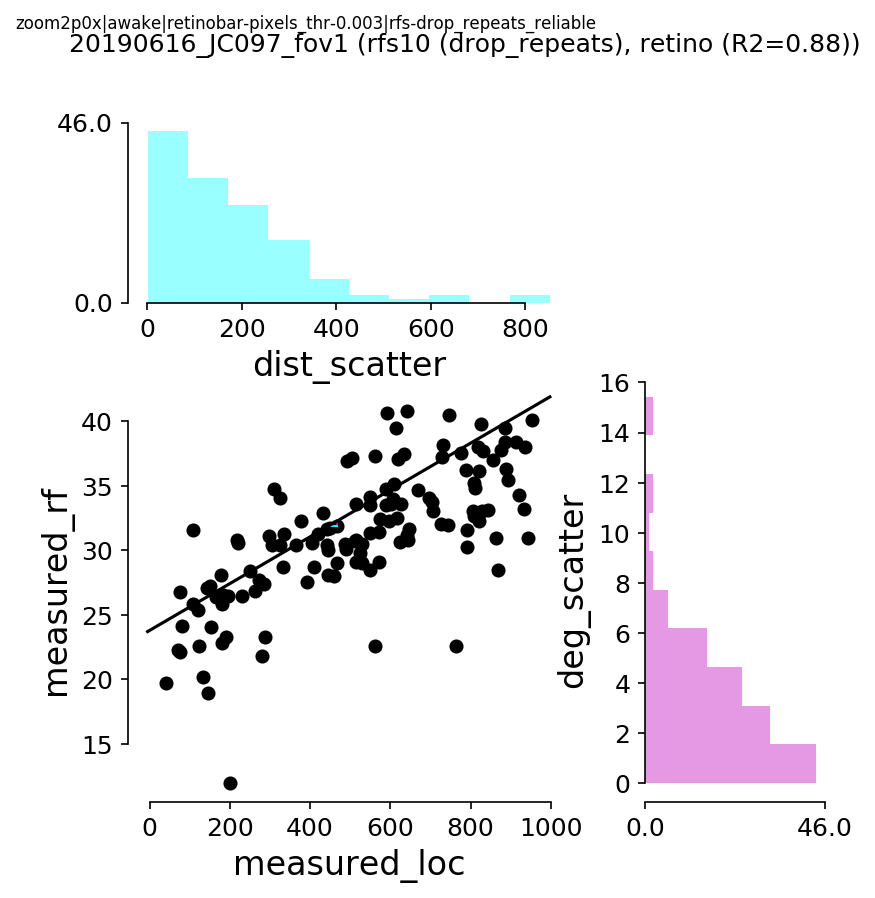

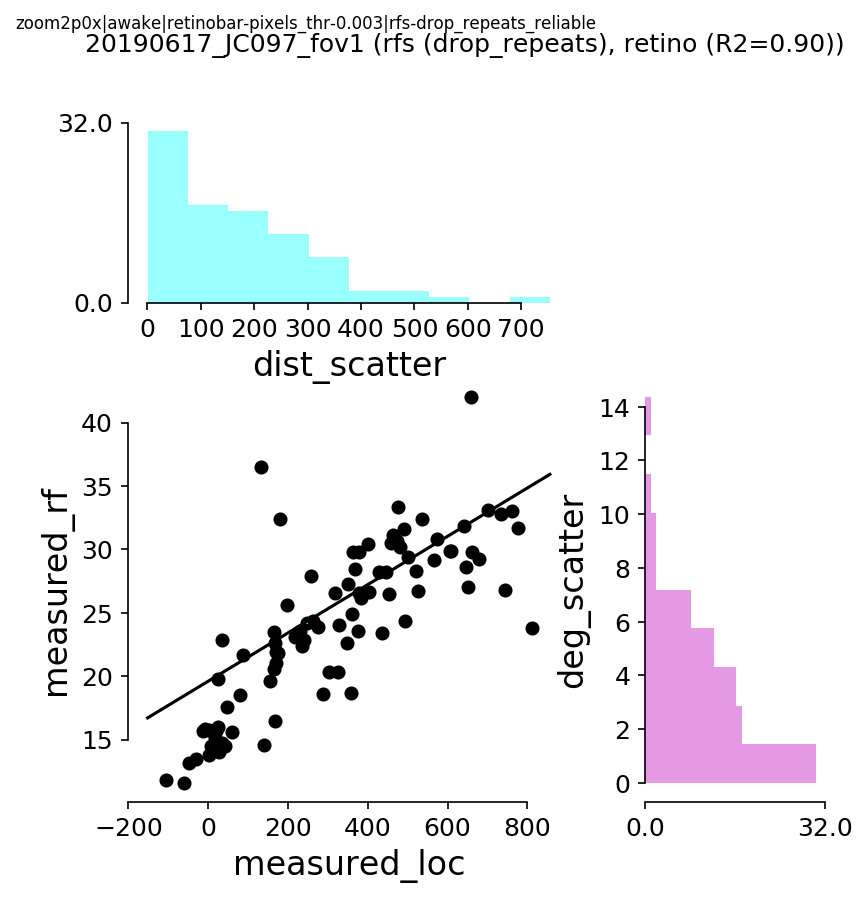

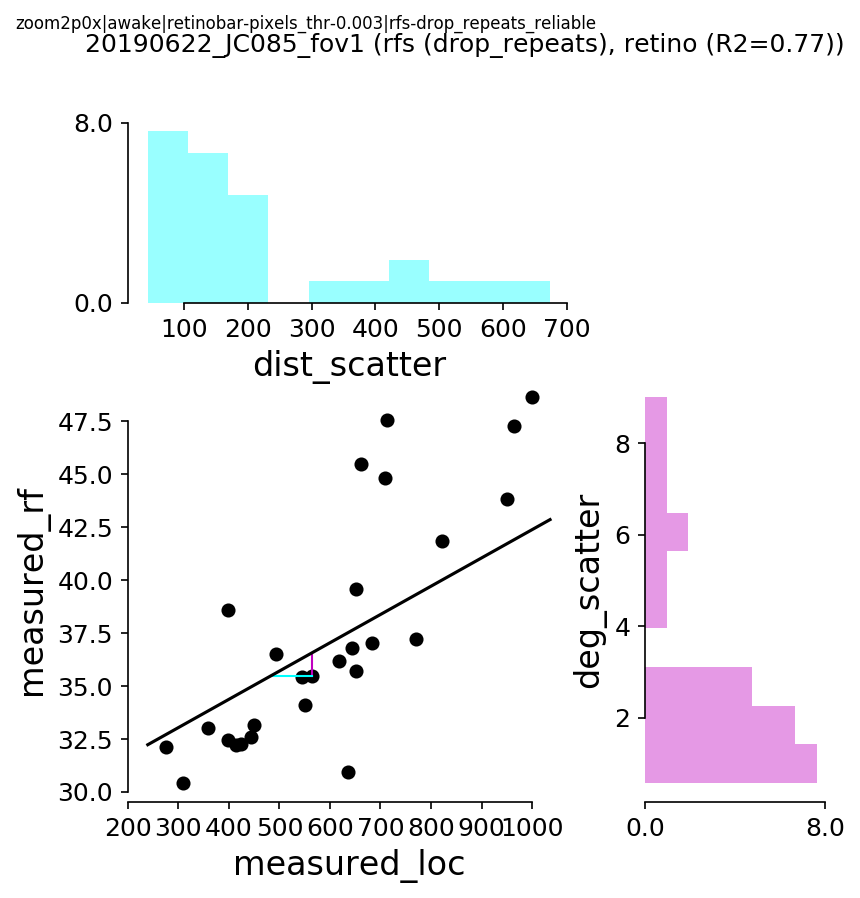

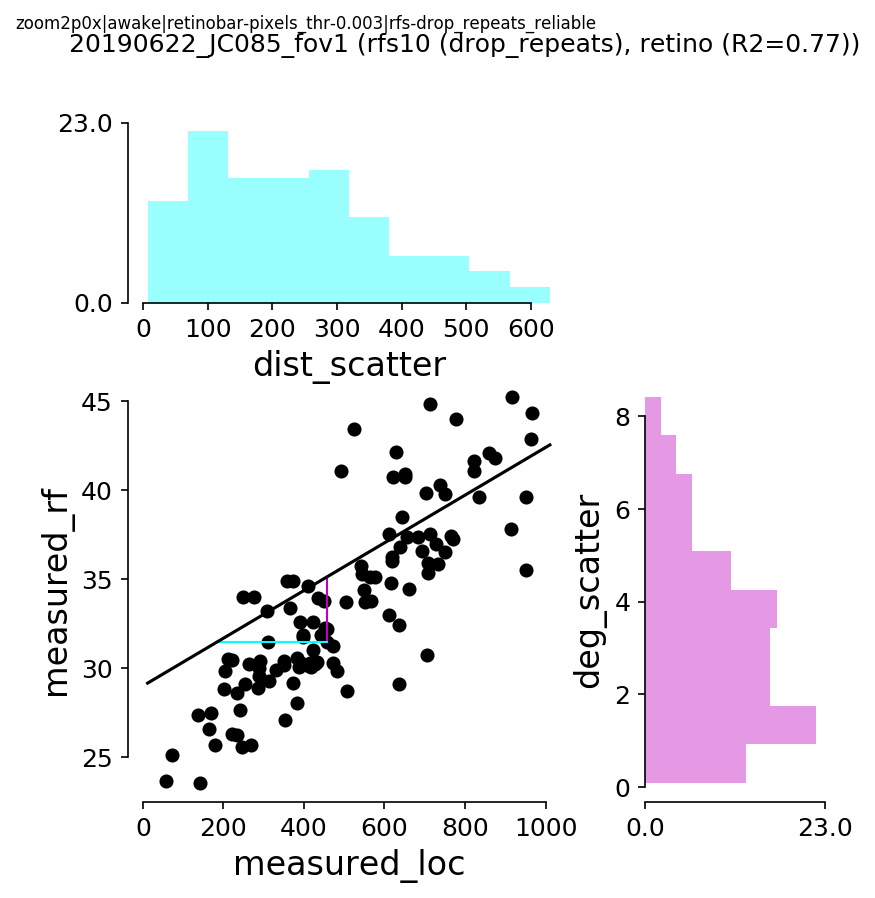

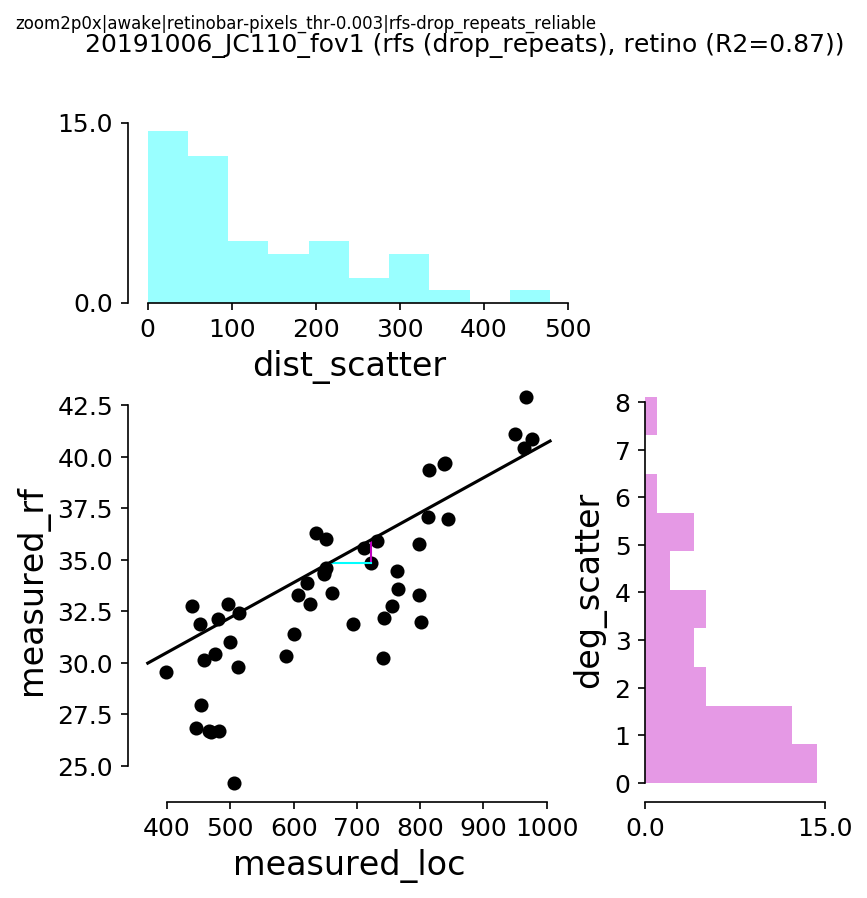

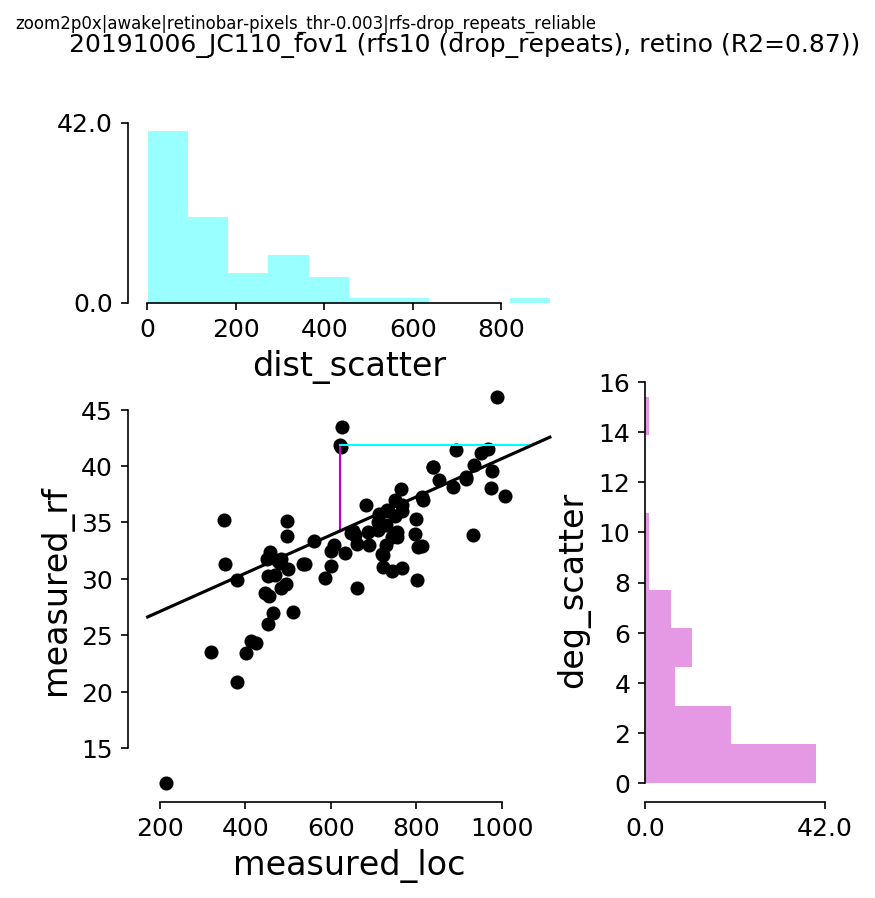

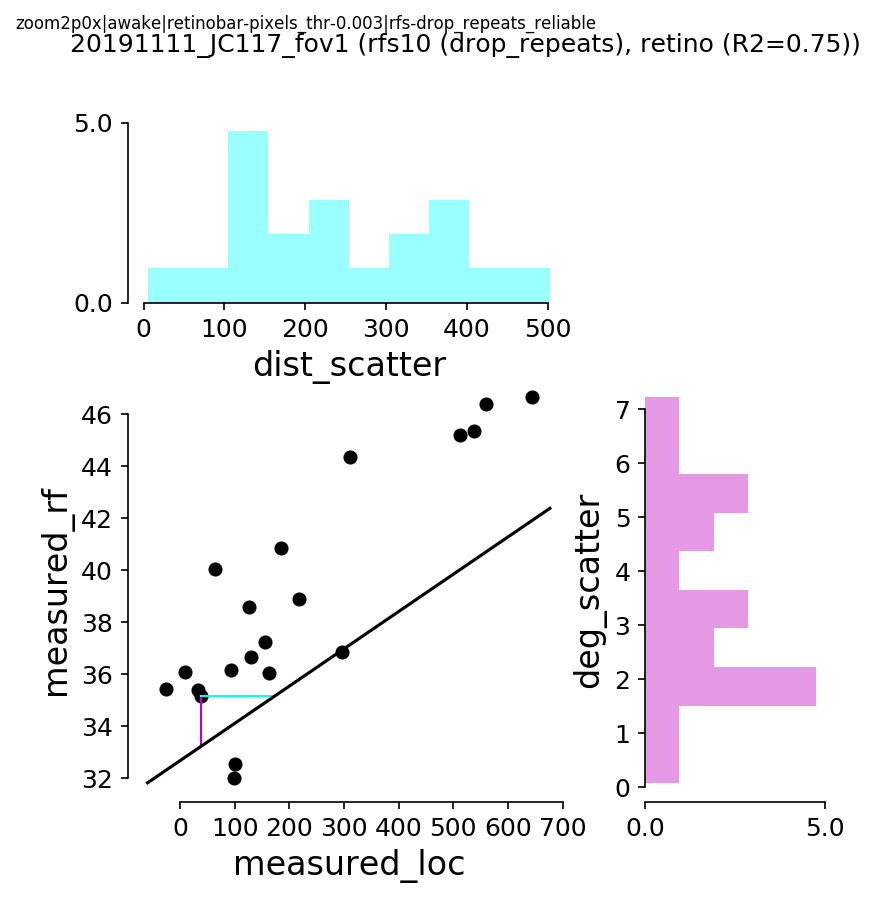

In [291]:
nbins=10
lw=3 
cond='az'

for (visual_area, datakey, rfname), rf_  in scatdf.groupby(['visual_area', 'datakey', 'rfname']):

    ret_ = projdf[projdf['datakey']==datakey]

    print(rf_.shape, ret_.shape)

    fig, scatterax = pl.subplots(figsize=(6,6), dpi=dpi)
    
    # Do scatter plot
    axdf = rf_[rf_['axis']==cond]
    sns.scatterplot(x='measured_loc', y='measured_rf', data=axdf, ax=scatterax,
                    color='k', edgecolor='k')
    slope = float(ret_[ret_['cond']==cond]['coefficient'])
    intercept = float(ret_[ret_['cond']==cond]['intercept'])
    r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ls = '-' if r2_v > retino_r2 else ':'
    
    # Plot Vert/Horz lines showing deg_scatter or dist_scatter
    npts = axdf.shape[0]
    #if npts>20:
    pt_ixs = [int(npts/2.)] #np.arange(0, npts, 10)
    for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
        if ii not in pt_ixs:
            continue
        # Do DEG scatter
        pred_deg = axdf['predicted_rf'].iloc[ii]
        offset_deg = axdf['deg_scatter'].iloc[ii]*-1 if yi>pred_deg else axdf['deg_scatter'].iloc[ii]
        scatterax.plot([xi,xi], [yi, yi+offset_deg], 'm', alpha=1, lw=lw)
        # Do DIST scatter
        pred_dist = axdf['predicted_loc'].iloc[ii]
        offset_dist = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred_dist else axdf['dist_scatter'].iloc[ii]    
        scatterax.plot([xi, xi+offset_dist], [yi, yi], 'cyan', alpha=1, lw=lw)
    # Draw regr line
    scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
                       color='k', label=False, label_prefix=label_prefix)

#     # Plot Vert/Horz lines showing deg_scatter or dist_scatter
#     for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
#         if ii not in pt_ixs:
#             continue
#         pred_dist = axdf['predicted_loc'].iloc[ii]
#         offset_dist = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred_dist else axdf['dist_scatter'].iloc[ii]    
#         scatterax.plot([xi, xi+offset_dist], [yi, yi], 'cyan', alpha=1, lw=lw)
#     scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
#                        color='k', label=False, label_prefix=label_prefix)

    # Create top/right histograms
    divider = make_axes_locatable(scatterax)
    histax_x = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
    histax_y = divider.append_axes("right", 1.2, pad=0.5, sharey=None) #scatterax)

    sns.distplot(axdf['dist_scatter'], color='cyan', ax=histax_x, kde=False, bins=nbins)
    histax_x.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_x.get_ylim()
    histax_x.set_yticks([xlim, ylim])
    histax_x.set_yticklabels([round(xlim), round(ylim)])
    histax_x.spines["right"].set_visible(False)
    histax_x.spines["left"].set_visible(True)
    histax_x.spines["top"].set_visible(False)
    histax_x.spines["bottom"].set_visible(True)


    sns.distplot(axdf['deg_scatter'], color='m', ax=histax_y, vertical=True, kde=False, bins=nbins)
    histax_y.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_y.get_xlim()
    histax_y.set_xticks([xlim, ylim])
    histax_y.set_xticklabels([round(xlim), round(ylim)])
    histax_y.spines["right"].set_visible(False)
    histax_y.spines["left"].set_visible(True)
    histax_y.spines["top"].set_visible(False)
    histax_y.spines["bottom"].set_visible(True)

    sns.despine(trim=True)
    pl.suptitle('%s (%s (%s), retino (R2=%.2f))' % (datakey, rfname, rf_filter_by, r2_v))

    label_figure(fig, data_id)

    figname = '%s_%s_%s_deg_v_dist_scatter' % (rfname, visual_area, datakey)
    pl.savefig(os.path.join(scatterfov_dir,'%s.svg' % figname))
    #print(scatterfov_dir, figname)

In [671]:
vdf_ax.head()

,axis,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,visual_area
0,az,20190613_JC097_fov1,7.275521,334.964654,799.145,39.905866,1134.109349,32.6303,0.916572,V1
1,az,20190613_JC097_fov1,0.057691,2.656077,476.072,25.555434,473.416143,25.6131,0.916572,V1
2,az,20190613_JC097_fov1,5.233501,240.950155,582.386,33.155796,823.336450,27.9223,0.916572,V1
3,az,20190613_JC097_fov1,2.484759,114.398174,813.273,35.421968,927.670898,32.9372,0.916572,V1
4,az,20190613_JC097_fov1,0.984448,45.323960,877.478,33.347307,832.153616,34.3318,0.916572,V1


In [73]:
[d for d in scatdf['datakey'].unique() if d not in rfdf['datakey'].unique()]


[]

In [257]:
scatter_datakeys = scatdf['datakey'].unique()
curr_rfs = rfdf[rfdf['datakey'].isin(scatter_datakeys)].copy()


In [258]:
curr_rfs[curr_rfs['experiment']=='rfs10'].groupby(['visual_area', 'datakey']).count()


r2  fwhm_x  fwhm_y  theta   x0   y0  \
visual_area datakey                                                     
Li          20190527_JC092_fov3   42      42      42     42   42   42   
            20190605_JC090_fov1   17      17      17     17   17   17   
            20190612_JC099_fov1   40      40      40     40   40   40   
            20190617_JC099_fov1   11      11      11     11   11   11   
            20191018_JC113_fov1   13      13      13     13   13   13   
Lm          20190618_JC097_fov1   28      28      28     28   28   28   
V1          20190613_JC097_fov1  107     107     107    107  107  107   
            20190616_JC097_fov1  131     131     131    131  131  131   
            20190622_JC085_fov1  115     115     115    115  115  115   
            20191006_JC110_fov1   87      87      87     87   87   87   
            20191111_JC117_fov1   21      21      21     21   21   21   

                                 animalid  cell  experiment  fovnum   ...     \
visual_area datakey                                                   ...      
Li          20190527_JC092_fov3        42    42          42      42   ...      
            20190605_JC090_fov1        17    17          17      17   ...      
            20190612_JC099_fov1        40    40          40      40   ...      
            20190617_JC099_fov1        11    11          11      11   ...      
            20191018_JC113_fov1        13    13          13      13   ...      
Lm          20190618_JC097_fov1        28    28          28      28   ...      
V1          20190613_JC097_fov1       107   107         107     107   ...      
            20190616_JC097_fov1       131   131         131     131   ...      
            20190622_JC085_fov1       115   115         115     115   ...      
            20191006_JC110_fov1        87    87          87      87   ...      
            20191111_JC117_fov1        21    21          21      21   ...      

                                 ratio_xy  theta_c  fov_xpos  fov_xpos_pix  \
visual_area datakey                                                          
Li          20190527_JC092_fov3        42       42        42            42   
            20190605_JC090_fov1        17       17        17            17   
            20190612_JC099_fov1        40       40        40            40   
            20190617_JC099_fov1        11       11        11            11   
            20191018_JC113_fov1        13       13        13            13   
Lm          20190618_JC097_fov1        28       28        28            28   
V1          20190613_JC097_fov1       107      107       107           107   
            20190616_JC097_fov1       131      131       131           131   
            20190622_JC085_fov1       115      115       115           115   
            20191006_JC110_fov1        87       87        87            87   
            20191111_JC117_fov1        21       21        21            21   

                                 fov_ypos  fov_ypos_pix  ml_pos  ap_pos  \
visual_area datakey                                                       
Li          20190527_JC092_fov3        42            42      42      42   
            20190605_JC090_fov1        17            17      17      17   
            20190612_JC099_fov1        40            40      40      40   
            20190617_JC099_fov1        11            11      11      11   
            20191018_JC113_fov1        13            13      13      13   
Lm          20190618_JC097_fov1        28            28      28      28   
V1          20190613_JC097_fov1       107           107     107     107   
            20190616_JC097_fov1       131           131     131     131   
            20190622_JC085_fov1       115           115     115     115   
            20191006_JC110_fov1        87            87      87      87   
            20191111_JC117_fov1        21            21      21      21   

                                 ml_proj  ap_proj  


In [259]:
figstr

'[retinobar_pixels-thr-0.003_rfs_drop_repeats-reliable]'

********* [rfs|median std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [rfs10|median std_avg] *********
[('V1', 'Lm')] p=0.487 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.002 (fdr_bh), reject H0=True
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'compare-size_RFvRF10_multicomp-fdr_bh__[retinobar_pixels-thr-0.003_rfs_drop_repeats-reliable]')


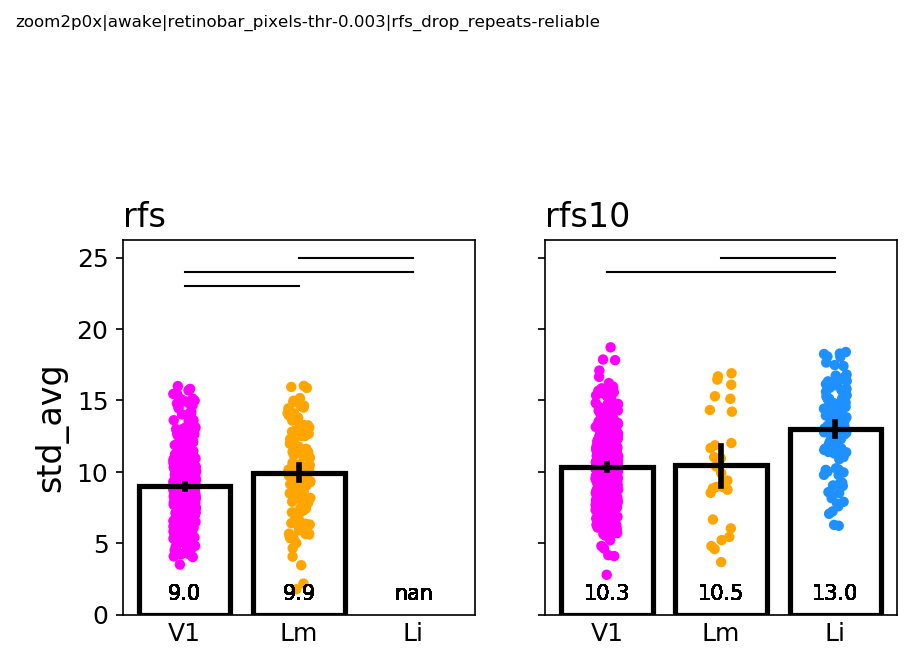

In [260]:
groupby='datakey'
curr_metric = 'std_avg'
fov_means = False
plot_bar = True

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'median' # median


fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, curr_rfs.groupby(['experiment']))):
    ax.patch.set_alpha(0)
        
    # Average RF sizes for each FOV
    grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
    mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()
    
    # Plot means
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=3, color='k')
    # Plot points
    plotdf = mean_sizes if fov_means else expdf
    point_size = 10 if fov_means else 5
    sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
                  zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                  s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                  marker='o',linewidth=1, edgecolor='none')
    
    expdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

    if ai>0:
        ax.set_ylabel('');
    ax.set_title(experiment, loc='left', fontsize=16)
    
    # Get counts of samples for legend
    #legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
    #ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.4), fontsize=8)
    ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
    
    # Annotate w stats
    print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
    y_loc = 16 if fov_means else 23
    statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

# ylim = 0 if fov_means else 0
# ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)
# sns.despine(offset=4, trim=True, bottom=True)

label_figure(fig, data_id)

figname = 'compare-size_RFvRF10_multicomp-%s__%s' % (multi_comp_test, figstr )
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)

In [322]:
scatdf.head()

,axis,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,rfname,visual_area
0,az,20190527_JC092_fov3,4.481396,44.398004,629.847,13.970935,585.448948,18.4523,0.979097,rfs10,Li
1,az,20190527_JC092_fov3,1.363426,13.507706,652.465,22.098769,665.972884,20.7353,0.979097,rfs10,Li
2,az,20190527_JC092_fov3,0.637502,6.315845,620.84,16.905663,614.523837,17.5432,0.979097,rfs10,Li
3,az,20190527_JC092_fov3,0.342061,3.388857,605.702,15.673189,602.313491,16.0152,0.979097,rfs10,Li
4,az,20190527_JC092_fov3,1.941626,19.236043,545.999,8.047331,526.762728,9.98896,0.979097,rfs10,Li


# Plot deg scatter vs. RF size

In [96]:
 rfs_.sort_values(by='cell')

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,ratio_xy,theta_c,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,ml_proj,ap_proj
1794,0.675311,14.479144,20.340325,5.618282,46.676663,19.609258,JC117,38,20191111_JC117_fov1,rfs10,...,0.711844,-0.664903,170.533,74,203.698,107,769.102,1007.07,643.405,780.049
1795,0.677843,18.577009,10.279799,0.907607,45.369820,17.403297,JC117,57,20191111_JC117_fov1,rfs10,...,1.807137,0.907607,135.966,59,306.499,161,666.301,1041.63,537.213,839.471
1797,0.662744,7.062421,6.066061,0.610350,46.394149,10.266367,JC117,80,20191111_JC117_fov1,rfs10,...,1.164252,0.610350,377.938,164,312.21,164,660.59,799.662,560.423,606.794
1799,0.648477,20.569622,37.331508,5.139156,44.351789,19.118887,JC117,111,20191111_JC117_fov1,rfs10,...,0.550999,-1.144029,115.225,50,531.137,279,441.663,1062.37,311.704,916.3
1800,0.663174,30.555625,18.731926,0.356615,36.041654,16.394740,JC117,119,20191111_JC117_fov1,rfs10,...,1.631206,0.356615,165.924,72,687.242,361,285.558,1011.68,162.767,906.691
1801,0.748208,25.936458,18.597811,0.518309,38.588540,15.074213,JC117,124,20191111_JC117_fov1,rfs10,...,1.394597,0.518309,244.277,106,732.932,385,239.868,933.323,126.756,842.426
1802,0.834812,36.714466,23.919213,0.485243,36.155169,14.534533,JC117,127,20191111_JC117_fov1,rfs10,...,1.534936,0.485243,195.883,85,761.487,400,211.313,981.717,92.6282,896.465
1803,0.702683,37.830913,46.120493,4.455394,36.090339,16.573667,JC117,132,20191111_JC117_fov1,rfs10,...,0.820263,1.313801,290.367,126,856.673,450,116.127,887.233,9.4,829.099
1804,0.765689,39.012935,36.010217,0.251292,32.001145,15.621962,JC117,137,20191111_JC117_fov1,rfs10,...,1.083385,0.251292,382.547,166,778.621,409,194.179,795.053,97.8967,720.188
1805,0.573065,38.544937,23.478599,3.768104,35.155299,15.623615,JC117,144,20191111_JC117_fov1,rfs10,...,1.641705,0.626511,596.866,259,864.288,454,108.512,580.734,38.4221,534.47


In [115]:
curr_scatter = pd.merge(d1, d2) #, axis=1)
curr_scatter['deg_scatter_mean'] = curr_scatter[['deg_scatter_el', 'deg_scatter_az']].mean(axis=1).drop_duplicates()
curr_scatter

,cell,deg_scatter_el,deg_scatter_az,deg_scatter_mean
0,1,4.331295,4.481396,4.406345
1,2,1.190516,1.363426,1.276971
2,4,1.137613,0.637502,0.887557
3,5,0.585691,0.342061,0.463876
4,9,0.399202,1.941626,1.170414
5,14,1.262204,1.425843,1.344024
6,15,1.112833,3.025463,2.069148
7,17,0.489607,1.470452,0.980030
8,19,6.177463,1.137969,3.657716
9,21,6.467332,4.504639,5.485985


In [118]:
curr_scatter['cell']

,cell,cell
0,1,1
1,2,2
2,4,4
3,5,5
4,9,9
5,14,14
6,15,15
7,17,17
8,19,19
9,21,21


In [120]:
rfname = 'rfs10'
scatter_cond='avg'
sz_param = 'std_avg' # if scatter_cond=='az' else 'fy'

#fig, axn = pl.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

d_list=[]
for (visual_area, datakey, rfname), sg in scatdf.groupby(['visual_area', 'datakey', 'rfname']):
    ai = visual_areas.index(visual_area)
    #ax = axn[ai]

    el_scatter = sg[sg['axis']=='el'][['cell', 'deg_scatter']]
    az_scatter = sg[sg['axis']=='az'][['cell', 'deg_scatter']]
    common_cells = np.intersect1d(el_scatter['cell'].unique(), az_scatter['cell'].unique())
    d1 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='el')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_el'})
    d2 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='az')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_az'})

    curr_scatter = pd.merge(d1, d2) #, axis=1)
    curr_scatter['deg_scatter_mean'] = curr_scatter[['deg_scatter_el', 'deg_scatter_az']].mean(axis=1)

    rfs_ = rfdf[(rfdf['datakey']==datakey) 
                    & (rfdf['experiment']==rfname)
                    & (rfdf['cell'].isin(curr_scatter['cell'].unique()))].copy()    
    # curr_sizes = rfs_.sort_values(by='cell')[sz_param].values
    df_ = pd.merge(rfs_, curr_scatter)
      
#     df_ = pd.DataFrame({'scatter_el': d1['deg_scatter_el'].values,
#                         'scatter_az': d2['deg_scatter_az'].values,
#                         'scatter_mean': curr_scatter,
#                         'fx': rfs_.sort_values(by='cell')['fx'].values,
#                         'fy': rfs_.sort_values(by='cell')['fy'].values,
#                         'rf_size': curr_sizes,
#                         'cell': common_cells})
#     metadict = {'rfname': rfname, 'visual_area': visual_area, 'datakey': datakey}
#     df_ = putils.add_meta_to_df(df_, metadict)
    d_list.append(df_)
    
    #pearson_r, pearson_p = spstats.pearsonr(df_[sz_param, curr_scatter)
    #print("[%s] %s (%s): r=%.2f (p=%.2f)" % (visual_area, datakey, rfname, pearson_r, pearson_p))
    
    #ax.scatter(curr_sizes, curr_scatter, c=dkey_colors[i])
    #ax.plot(0, 0, alpha=1., marker='x', markersize=0.1,  color=dkey_colors[i], label='pearson r=%.2f (p=%.2f)' % (pearson_r, pearson_p))

avg_scatter = pd.concat(d_list, axis=0)
print(d_list[0].shape, avg_scatter.shape)

((41, 34), (1230, 34))


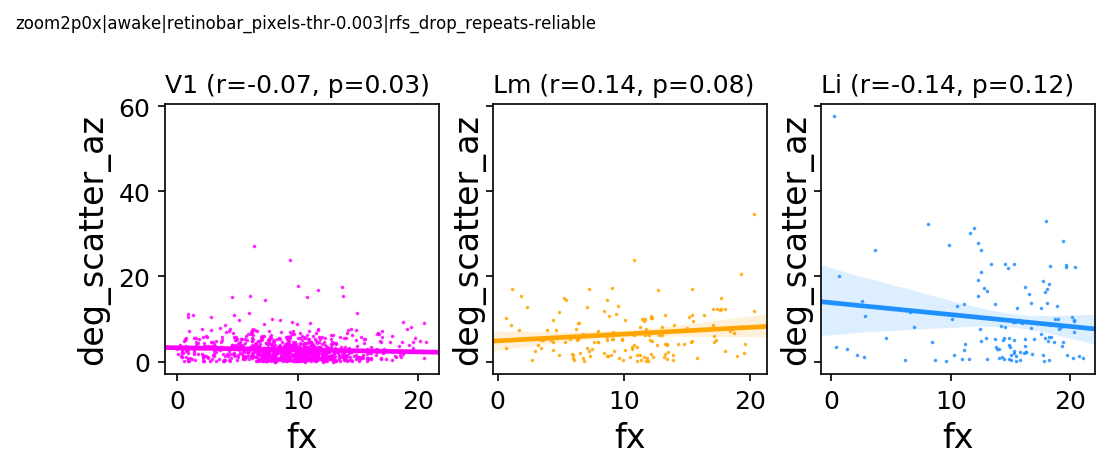

In [122]:
xval = 'fx'
yval = 'deg_scatter_az'
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter.groupby(['visual_area'])):
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)

# pl.savefig(os.path.join(gradient_dir, 'size_v_scatter_all-rfs.svg'))

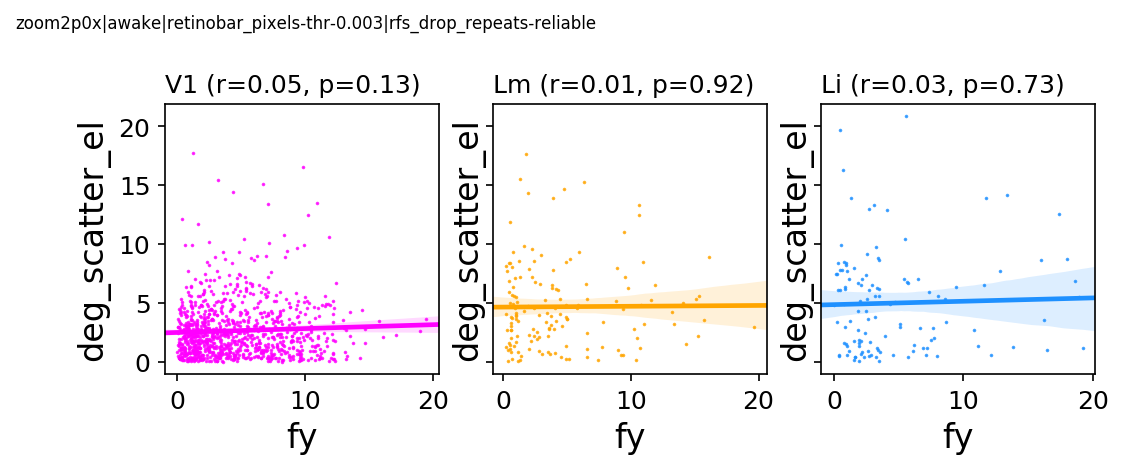

In [123]:
xval = 'fy'
yval = 'deg_scatter_el'
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter.groupby(['visual_area'])):
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)


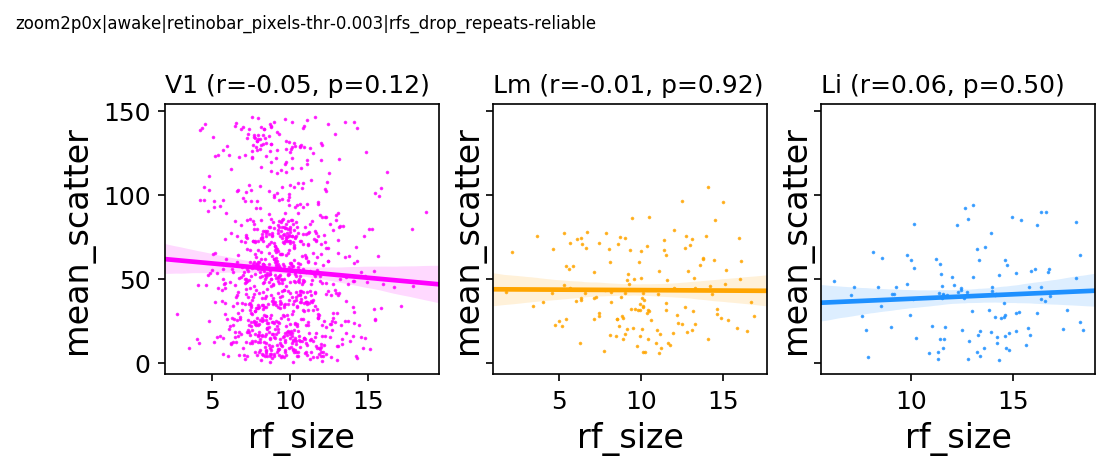

In [83]:
xval = 'rf_size'
yval = 'mean_scatter'
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter.groupby(['visual_area'])):
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)


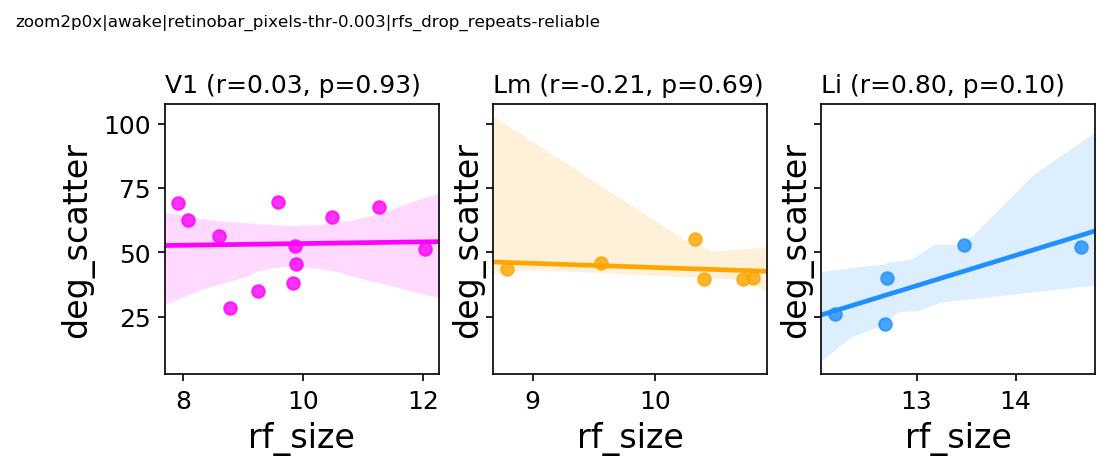

In [281]:
means = avg_scatter.groupby(['visual_area', 'datakey', 'rfname']).mean().reset_index()


fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], means.groupby(['visual_area'])):
    sns.regplot('rf_size', 'deg_scatter', color=area_colors[visual_area], data=g, ax=ax)
    r, p = spstats.pearsonr(g['rf_size'].values, g['deg_scatter'].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
    
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)
putils.label_figure(fig, data_id)
    
pl.savefig(os.path.join(gradient_dir, 'size_v_scatter_all-rfs_avg-by-fov.svg'))

In [143]:
mean_scatter

0      4.406345
1      1.276971
2      0.887557
3      0.463876
4      1.170414
5      1.344024
6      2.069148
7      0.980030
8      3.657716
9      5.485985
10     4.001453
11     2.039994
12     3.295844
13     1.540034
14     1.811768
15     3.963037
16     0.727967
17     1.617361
18     2.427148
19     3.368217
20     3.112076
21     5.336003
22     3.995265
23     5.885869
24     8.132604
25     4.967466
26     4.999639
27     4.142185
28     8.519754
29     6.223357
30     6.700402
31     7.619141
32     4.235207
33     5.321832
34     7.943831
35     6.081890
36     7.098965
37     6.323240
38    57.611104
39     2.224720
40     0.601756
41     3.510178
dtype: float64

In [108]:
curr_rfs.shape, curr_scatt.shape

((10, 31), (123, 12))

# Test w mixed df

In [267]:
r_list=[]
for (visual_area, datakey), g in rfdf.groupby(['visual_area', 'datakey']):
    if ('rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values):
        print('%s: %s' % (visual_area, datakey))
        if visual_area=='Li':
            r_list.append(g[g['experiment']=='rfs10'])
        else:
            r_list.append(g[g['experiment']=='rfs'])
    else:
        r_list.append(g)
mixdf = pd.concat(r_list, axis=0).reset_index(drop=True)


Li: 20190522_JC089_fov1
Lm: 20190618_JC097_fov1
V1: 20190613_JC097_fov1
V1: 20190616_JC097_fov1
V1: 20190622_JC085_fov1
V1: 20191006_JC110_fov1


In [268]:
#rfname = 'rfs10'
retino_r2_thr=0.75
min_ncells=5
retino_pass_crit='both' 

if retino_pass_crit=='both':
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2_thr) \
                                and (g[g['cond']=='el']['R2'].values>retino_r2_thr))])
else:
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2_thr) \
                                or (g[g['cond']=='el']['R2'].values>retino_r2_thr))])

curr_gradients = filtproj.copy()

not_enough_cells_fit = []
bad_fits = []
d_list = []
for (visual_area, datakey, rfname), rfs_ in mixdf.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:
    print("[%s] %s (%s)" % (visual_area, datakey, rfname))
    
    if rfs_.shape[0] < min_ncells:
        print("--- too few cells (min%i), %s" % (min_ncells, datakey))
        not_enough_cells_fit.append(datakey)
        continue
    if datakey not in curr_gradients['datakey'].unique():
        print("--- bad gradient, %s" % datakey)
        continue

    # Get retino gradient
    #retinorun = curr_gradients[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()
    ret_ = curr_gradients[curr_gradients['datakey']==datakey].copy()
    
    for cond, ret_cond in ret_.groupby(['cond']):
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'
        max_degrees = screen['azimuth_deg'] if cond=='az' else screen['altitude_deg']
        max_fovdist = 1177 if cond=='ap' else 972.
        
        # Get RF fit info
        proj_locs = np.array(rfs_['%s_proj' % xname].values)
        rf_locs = np.array(rfs_[yname].values)
        rf_cell_ids = rfs_['cell'].values
        
        # Get dist to line:
        slope = float(ret_cond['coefficient'])
        intercept = float(ret_cond['intercept'])
        r2 = float(ret_cond['R2'])
        predicted_rf_locs = slope*proj_locs + intercept
        
        # Calculate DEG and DIST scattered
        deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
        deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
        dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
        dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
        keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
        n_pts = len(keep_ixs)
        if (n_pts)==0:
            bad_fits.append((datakey, cond))
            continue
        print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
        print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
        assert len(rf_cell_ids)==len(deg_sc)
            
        if any(np.isnan(dist_sc)):
            print(visual_area, datakey, r2)
        if any(np.isnan(deg_sc)):
            print(visual_area, datakey, r2)
        tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                           'deg_scatter': deg_sc[keep_ixs],
                           'dist_scatter': dist_sc[keep_ixs],
                           'measured_rf': rf_locs[keep_ixs],
                           'predicted_rf': predicted_rf_locs[keep_ixs],
                           'measured_loc': proj_locs[keep_ixs],
                           'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                           'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                           'axis': [cond for _ in np.arange(0, n_pts)],
                           'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                           'datakey': [datakey for _ in np.arange(0, n_pts)],
                           'rfname': [rfname for _ in np.arange(0, n_pts)]
                     })
        d_list.append(tmpd)
scatdf_mixed = pd.concat(d_list, axis=0)
print(scatdf_mixed.shape)
scatdf_mixed.head()

[Li] 20190522_JC089_fov1 (rfs10)
--- bad gradient, 20190522_JC089_fov1
[Li] 20190527_JC092_fov3 (rfs10)
... (az) deg: 42 of 42 in bounds
... (az) dist: 42 of 42 in bounds
... (el) deg: 42 of 42 in bounds
... (el) dist: 38 of 42 in bounds
[Li] 20190528_JC092_fov1 (rfs10)
--- bad gradient, 20190528_JC092_fov1
[Li] 20190605_JC090_fov1 (rfs10)
... (az) deg: 17 of 17 in bounds
... (az) dist: 17 of 17 in bounds
... (el) deg: 17 of 17 in bounds
... (el) dist: 15 of 17 in bounds
[Li] 20190607_JC091_fov1 (rfs10)
--- bad gradient, 20190607_JC091_fov1
[Li] 20190612_JC099_fov1 (rfs10)
... (az) deg: 40 of 40 in bounds
... (az) dist: 40 of 40 in bounds
... (el) deg: 40 of 40 in bounds
... (el) dist: 40 of 40 in bounds
[Li] 20190614_JC091_fov1 (rfs10)
--- bad gradient, 20190614_JC091_fov1
[Li] 20190617_JC099_fov1 (rfs10)
... (az) deg: 11 of 11 in bounds
... (az) dist: 11 of 11 in bounds
... (el) deg: 11 of 11 in bounds
... (el) dist: 11 of 11 in bounds
[Li] 20191003_JC111_fov1 (rfs10)
--- bad gradien

,axis,cell,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,rfname,visual_area
0,az,1,20190527_JC092_fov3,4.481396,44.398004,629.847,13.970935,585.448948,18.4523,0.979097,rfs10,Li
1,az,2,20190527_JC092_fov3,1.363426,13.507706,652.465,22.098769,665.972884,20.7353,0.979097,rfs10,Li
2,az,4,20190527_JC092_fov3,0.637502,6.315845,620.84,16.905663,614.523837,17.5432,0.979097,rfs10,Li
3,az,5,20190527_JC092_fov3,0.342061,3.388857,605.702,15.673189,602.313491,16.0152,0.979097,rfs10,Li
4,az,9,20190527_JC092_fov3,1.941626,19.236043,545.999,8.047331,526.762728,9.98896,0.979097,rfs10,Li


In [271]:

d_list=[]
for (visual_area, datakey), sg in scatdf_mixed.groupby(['visual_area', 'datakey']):

    el_scatter = sg[sg['axis']=='el'][['cell', 'deg_scatter']]
    az_scatter = sg[sg['axis']=='az'][['cell', 'deg_scatter']]
    
    common_cells = np.intersect1d(el_scatter['cell'].unique(), az_scatter['cell'].unique())
    d1 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='el')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_el'})
    d2 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='az')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_az'})
    curr_scatter = pd.merge(d1, d2).sort_values(by='cell').mean(axis=1).values
    
    rfs_ = mixdf[(mixdf['datakey']==datakey) 
                    & (mixdf['cell'].isin(common_cells))].copy()    
    curr_sizes = rfs_.sort_values(by='cell')[sz_param].values
    
    df_ = pd.DataFrame({'deg_scatter': curr_scatter,
                        'rf_size': curr_sizes,
                        'cell': common_cells})
    metadict = {'visual_area': visual_area, 'datakey': datakey}
    df_ = putils.add_meta_to_df(df_, metadict)
    d_list.append(df_)
    
    pearson_r, pearson_p = spstats.pearsonr(curr_sizes, curr_scatter)
    print("[%s] %s (%s): r=%.2f (p=%.2f)" % (visual_area, datakey, rfname, pearson_r, pearson_p))
    
avg_scatter_mix = pd.concat(d_list, axis=0)
print(d_list[0].shape, avg_scatter_mix.shape)

[Li] 20190527_JC092_fov3 (rfs10): r=-0.13 (p=0.45)
[Li] 20190605_JC090_fov1 (rfs10): r=-0.34 (p=0.21)
[Li] 20190612_JC099_fov1 (rfs10): r=-0.12 (p=0.45)
[Li] 20190617_JC099_fov1 (rfs10): r=-0.43 (p=0.19)
[Li] 20191018_JC113_fov1 (rfs10): r=0.56 (p=0.07)
[Lm] 20190513_JC078_fov1 (rfs10): r=0.16 (p=0.52)
[Lm] 20190517_JC083_fov1 (rfs10): r=0.47 (p=0.02)
[Lm] 20190603_JC080_fov1 (rfs10): r=-0.12 (p=0.39)
[Lm] 20190618_JC097_fov1 (rfs10): r=-0.09 (p=0.76)
[Lm] 20190627_JC091_fov1 (rfs10): r=-0.11 (p=0.78)
[V1] 20190511_JC083_fov1 (rfs10): r=-0.06 (p=0.72)
[V1] 20190522_JC084_fov1 (rfs10): r=-0.13 (p=0.16)
[V1] 20190613_JC097_fov1 (rfs10): r=-0.07 (p=0.57)
[V1] 20190616_JC097_fov1 (rfs10): r=-0.05 (p=0.61)
[V1] 20190617_JC097_fov1 (rfs10): r=-0.24 (p=0.02)
[V1] 20190622_JC085_fov1 (rfs10): r=-0.26 (p=0.28)
[V1] 20191006_JC110_fov1 (rfs10): r=0.05 (p=0.75)
[V1] 20191111_JC117_fov1 (rfs10): r=0.55 (p=0.02)
((38, 5), (737, 5))


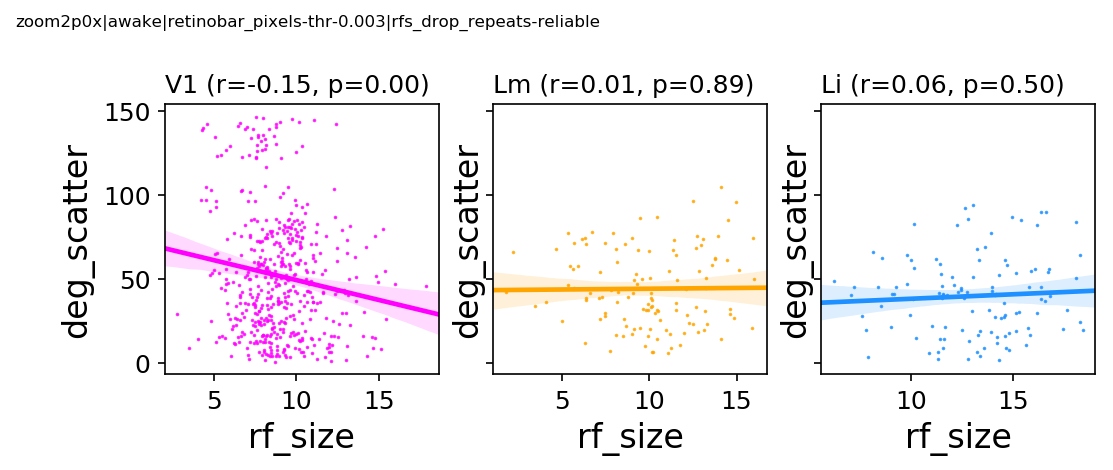

In [280]:
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter_mix.groupby(['visual_area'])):
    sns.regplot('rf_size', 'deg_scatter', color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g['rf_size'].values, g['deg_scatter'].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)

pl.savefig(os.path.join(gradient_dir, 'size_v_scatter_mixed-rfs.svg'))

In [284]:
avg_scatter_mix

,cell,deg_scatter,rf_size,datakey,visual_area
0,1,3.270897,7.904171,20190527_JC092_fov3,Li
1,2,1.517981,14.282056,20190527_JC092_fov3,Li
2,4,1.925038,11.334576,20190527_JC092_fov3,Li
3,5,1.975917,12.807153,20190527_JC092_fov3,Li
4,9,3.780276,13.369199,20190527_JC092_fov3,Li
5,14,5.562682,10.886278,20190527_JC092_fov3,Li
6,15,6.379432,11.292199,20190527_JC092_fov3,Li
7,17,6.320020,13.228646,20190527_JC092_fov3,Li
8,19,8.771811,11.538789,20190527_JC092_fov3,Li
9,21,10.657323,15.609910,20190527_JC092_fov3,Li


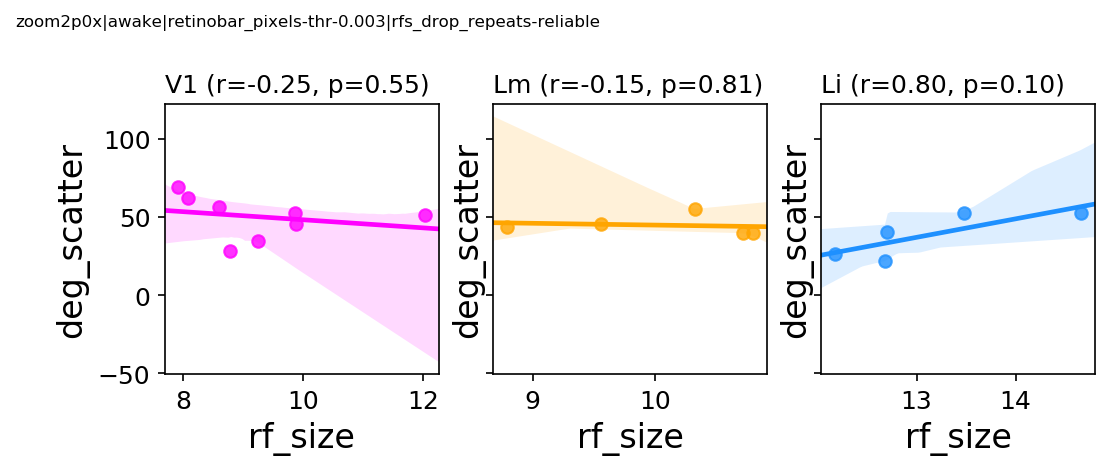

In [283]:
means_mix = avg_scatter_mix.groupby(['visual_area', 'datakey']).mean().reset_index()


fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], means_mix.groupby(['visual_area'])):
    sns.regplot('rf_size', 'deg_scatter', color=area_colors[visual_area], data=g, ax=ax)
    r, p = spstats.pearsonr(g['rf_size'].values, g['deg_scatter'].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
    
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)
putils.label_figure(fig, data_id)
    
pl.savefig(os.path.join(gradient_dir, 'size_v_scatter_mixed-rfs_avg-by-fov.svg'))

********* [std_avg] *********
[('V1', 'Lm')] p=0.018 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [deg_scatter] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.001 (fdr_bh), reject H0=True
rfsize_v_degscatter_plot-cells_avg-conds_fdr_bh__rfs-drop_repeats_retino-R2-0.75-both


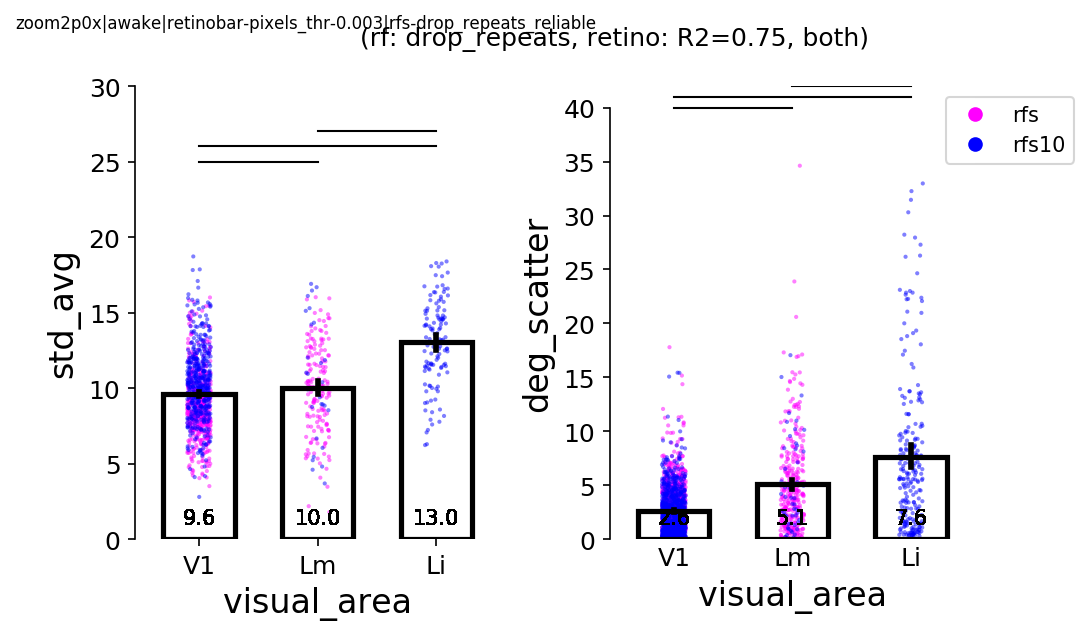

In [343]:
plot_cells=True
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))
multi_comp_test='fdr_bh'
marker_size = 2 if plot_cells else 10


plot_str = 'plot-cells' if plot_cells else 'plot-fov-means'

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, axn = pl.subplots(1, 2, figsize=(8,4), dpi=dpi, sharey=plot_cells==False)
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
plotter='std_avg'
ax=axn[0]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 25 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 30])

plotter='deg_scatter'
plotdf = scatdf.copy()
meandf = scatdf.groupby(['visual_area', 'datakey', 'rfname']).mean().reset_index()
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
ax=axn[1]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 40 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 42])


lines = [Line2D([0], [0], color=c, marker='o', linewidth=0, linestyle='-') for c in rfcolors]
ax.legend(lines, rfnames, bbox_to_anchor=(1.3, 1))


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.8)  

fig.suptitle('(rf: %s, retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))


figname = 'rfsize_v_degscatter_%s_avg-conds_%s__rfs-%s_retino-R2-%.2f-%s' % (plot_str, multi_comp_test, rf_filter_by, retino_r2, retino_pass_crit)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [ ]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

In [336]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

,r2,fwhm_x,fwhm_y,theta,x0,y0,cell,fovnum,std_x,std_y,fwhm_avg,std_avg,area,datakey_ix,fx,fy,ratio_xy,theta_c,fov_xpos_pix,fov_ypos_pix
visual_area,,,,,,,,,,,,,,,,,,,,
Li,0.725659,36.695878,24.782851,3.402446,11.969885,-7.519402,98.780501,1.4,15.615267,10.545894,30.739365,13.080581,528.339053,8.800000,14.644286,4.370316,1.613396,-0.020717,225.234368,253.177144
Lm,0.641087,27.715356,19.726997,3.082428,20.432486,-1.132121,119.879105,1.0,11.793768,8.394467,23.721176,10.094117,327.043466,5.714286,10.644018,4.236674,1.538102,-0.025542,267.771922,225.094960
V1,0.662040,24.725713,20.888310,2.973510,28.547671,-1.669245,150.202183,1.0,10.521580,8.888642,22.807012,9.705111,303.839387,4.583333,9.410404,4.642540,1.279471,0.038967,182.556537,252.239169


In [ ]:
plot_cells=False
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()
plotter='std_avg'

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, ax = pl.subplots()

#if barplot:
sns.barplot("visual_area", plotter, data=plotdf, ax=ax,
           hue='experiment', order=visual_areas, errcolor="k", hue_order=rfnames,
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .4)

sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf, #[meandf['experiment']=='rfs'], 
              dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             palette=rfcolor_dict, alpha=0.5, order=['V1', 'Lm', 'Li'])

# sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf[meandf['experiment']=='rfs10'], 
#               dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
#              palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
ax.legend_.remove()

plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
#scatdf[scatdf['rfname']=='rfs'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='m')
#scatdf[scatdf['rfname']=='rfs10'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='c')

rfutils.set_split_xlabels(ax, a_label=rfnames[0], b_label=rfnames[1])
#ax.legend_.remove()


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

fig.suptitle('RF %s size (RF: %s, Retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))